In [1]:
import aligater as ag
import pandas as pd
import numpy as np
from math import inf
import datetime
import re
import os
import sys

AliGater started in Jupyter mode


In [2]:
path_to_files = "/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs" 

In [3]:
def get_blacklist():
    #TODO: the plan was to edit the strings so that only file name is returned
    #but AliGater's mask feature seems to work fine with the full path name
    blacklist = ['/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs/181203 CB/C7 98.fcs',
                 '/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs/190401 CB/D3 333.fcs',
                 '/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs/190610 CB/C7 529.fcs',
                 '/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs/190610 CB/C8 530.fcs',
                 '/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs/190701 CB/C6 616.fcs',
                 '/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs/190715 CB/D6 651.fcs',
                 '/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs/190909 CB/E8 848.fcs']

    return blacklist

In [4]:
def get_filepaths(maxDate=None, minSampleID=None, maxSampleID=None, includeRepeats=False):
    """
    get_filepaths ceates a list with the exact filepath to each sample fcs file of interest.
    
    :maxDate: is a datetime date object that rejecs all samples OLDER than the specified date
    :maxSampleNum: is an int that limits the max CBID value allowed
    :includeRepeats: is a bool that determines wether or not to include additional
    .fcs files of samples that have been measured more than once.
    
    :return: this function returns a list of filepaths
    
    """
    if maxDate is None:
        maxdate = datetime.date(2021,6,24) #last date we are interested in
        print("No maximum date selected for the samples. Default cutoff is "+str(maxdate))
        
    relevant_folder_paths = []
    all_folders = sorted(os.listdir(path_to_files))  # Take ALL the folder names in 'fcs'
    if '.DS_Store' in all_folders: all_folders.remove('.DS_Store') #damn mac hidden files...
    
    for folder in all_folders:  # For each subfolder, check if we want it and if so append to 'relevabt_folder_paths'
        name_correction = False
        if folder.startswith('Natsumi-'): #Workaround for foldernames that start with 'Natsumi'
            name_correction = True
            og_foldername = folder
            folder = folder[8:]
        folder_date = datetime.date(int('20'+folder[:2]),int(folder[2:4]),int(folder[4:6]))  # Take date from folder name
        if folder_date > maxdate: # If we exceed the max date, stop
            continue
        if name_correction:
            folder = og_foldername
        #Add the folder name to the list of folders of interest
        relevant_folder_paths.append(path_to_files+"/"+folder)  # Add the complete path to the subfolders
    
    fcs_filepaths = []  # List of all fcs files.   
    for subfolder in relevant_folder_paths:
        for file in os.listdir(subfolder):
            if file.endswith('.fcs'):
                fcs_filepaths.append(subfolder+"/"+file)
    
    CBID_dict = dict()
    cbid_list = []
    for fcs in fcs_filepaths:
        cbid_dot_fcs = fcs.split('/')[-1].split(' ')[-1]
        cbid = cbid_dot_fcs.split('.')[0]
        if cbid.isdigit():
            if cbid in CBID_dict.keys(): #Append fcs filepath to the list corresponding to that key
                CBID_dict.setdefault(cbid, []).append(fcs) #append new value to list inside dict
    
            else: #if no key exists for that CBID yet
                CBID_dict[cbid] = [fcs]
    
            cbid_list.append(cbid) #Make list of cbids to use later as keys
    cbid_list = sorted(list(set(cbid_list)), key=int)
    if minSampleID:
        cbid_list = [x for x in cbid_list if int(x) >= int(minSampleID)]
    if maxSampleID:
        cbid_list = [x for x in cbid_list if int(x) <= int(maxSampleID)]
        
    final_filepaths = []
    repeat_filepaths = []
    unique_sample_fcs_filepaths = []
    for cbid in cbid_list:
        if includeRepeats and (len(CBID_dict[cbid]) >= 2): #If YES repeats and cbid has more than 2 samples associated
            final_filepaths.append(CBID_dict[cbid][-2]) #Second to last element of the corresponding list
            final_filepaths.append(CBID_dict[cbid][-1]) #Last element of the corresponding list
            
            #Add repeats only to additional list
            repeat_filepaths.append(CBID_dict[cbid][-2])
        else: #if no repeats or cbid only has single fcs file
            final_filepaths.append(CBID_dict[cbid][-1]) #Last element of the corresponding list
        unique_sample_fcs_filepaths.append(CBID_dict[cbid][-1])
    
    #NOTE: the latest fcs file for each CBID is considered to be the 'original', while older files are considered repeats
        
    print('Available samples:\n\tAll .fcs files: ', len(fcs_filepaths))
    print('\tUnique sample .fcs files included: ', len(unique_sample_fcs_filepaths))
    print('\tNumber of .fcs files in the final list of files to analyze:', len(final_filepaths))
    print('\tNumber of .fcs files belonging to repeats included: ', len(repeat_filepaths))

    return final_filepaths

In [5]:
filepaths=get_filepaths()
CB_exp=ag.AGExperiment(filepaths, filters=['fcs'], mask=['30min','45min','Neg','test']+get_blacklist(),\
           experiment_name="cord_blood_notebook_experiment",\
           flourochrome_area_filter=True, QC=True, QCbins=128)

No maximum date selected for the samples. Default cutoff is 2021-06-24
Available samples:
	All .fcs files:  3662
	Unique sample .fcs files included:  3036
	Number of .fcs files in the final list of files to analyze: 3036
	Number of .fcs files belonging to repeats included:  0


1 filter(s) defined
11 mask(s) defined
QC requested
Experiment initialised with file list. Checking entries...
All file paths exists.
Collected 2976 files, 60 files did not pass filter(s) and mask(s).


In [6]:
#Select 1 sample
#my_sample = ag.loadFCS(path_to_files+'/200316 CB/A2 1250.fcs', metadata=False, flourochrome_area_filter=True, return_type="agsample")
#my_sample = ag.loadFCS(path_to_files+'/190401 CB/E3 341.fcs', metadata=False, flourochrome_area_filter=True, return_type="agsample")

#OK sample:
my_sample = ag.loadFCS(path_to_files+'/190826 CB/D4 777.fcs', metadata=False, flourochrome_area_filter=True, return_type="agsample")


Opening file D4 777 from folder /fcs/190826 CB


In [7]:
 #Setup
ag.agconf.ag_verbose=True ##verbose ON
sample_filepath = my_sample.filePath
date_plate = ag.getFileName(ag.getParent(sample_filepath))
sampleName = ag.getFileName(sample_filepath)

event_cap = 3500000
if len(my_sample()) > event_cap:  ## Cap samples with too many events. Take only the first 3.5M
    my_sample.fcsDF = my_sample.fcsDF.iloc[0:event_cap]
    sys.stderr.write("Event cap reached. Downsapmled to "+str(event_cap)+" events.\n")
#Put inconsistent marker names into variables
markers = my_sample().columns.tolist()
for marker in markers[6:]:
    if marker.startswith('CD45'):
        CD45 = marker
    if marker.startswith('7AAD') or marker.startswith('CD235'):
        marker_7AAD = marker    

## Gate 1:  Viable/non-viable separation through 7AAD

/home/antton/Programs/aligater/aligater/AGPlotRoutines.py:201: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  cmap.set_bad(color='white') #Zeroes should be white, not blue


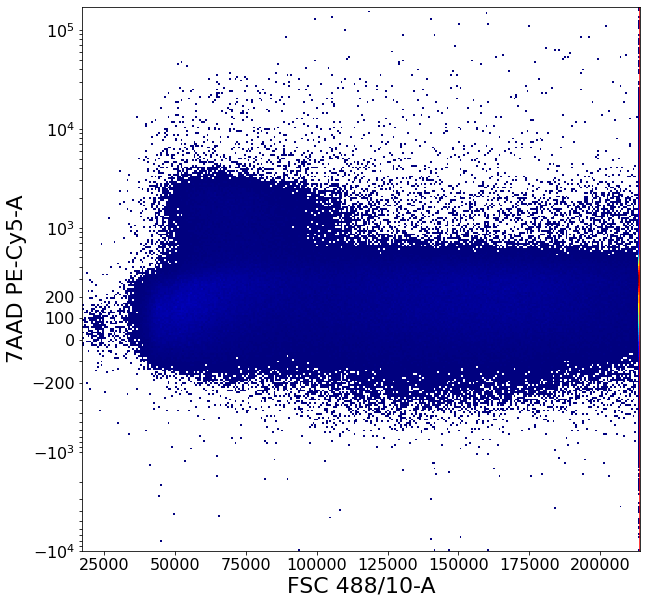

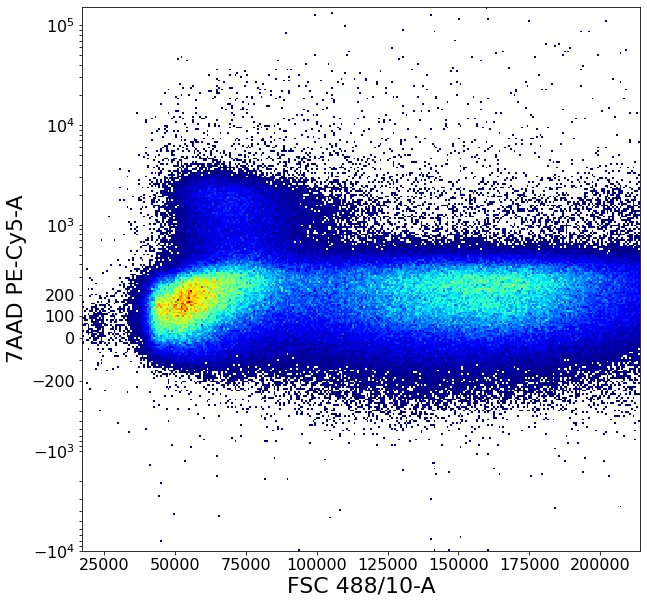

After gating, 447262 out of 513129 events remain.


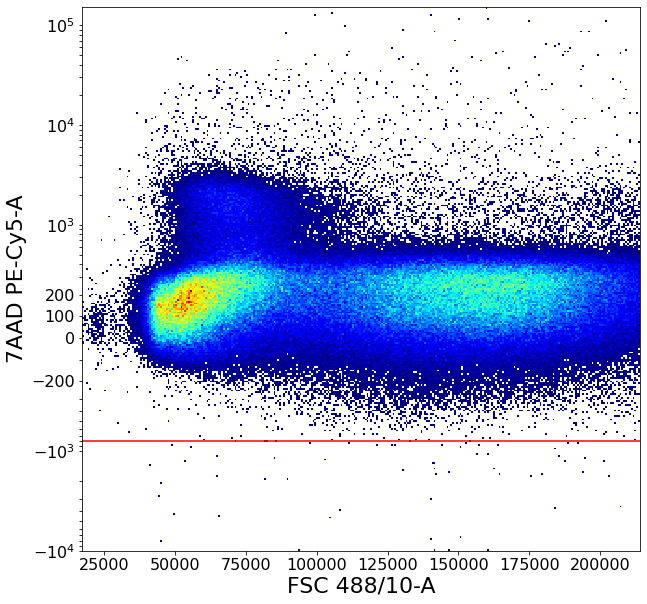

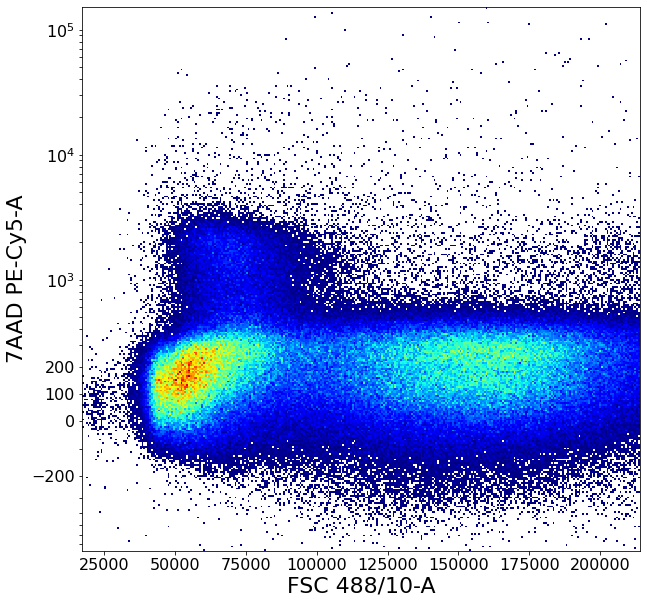

After gating, 447202 out of 447262 events remain.


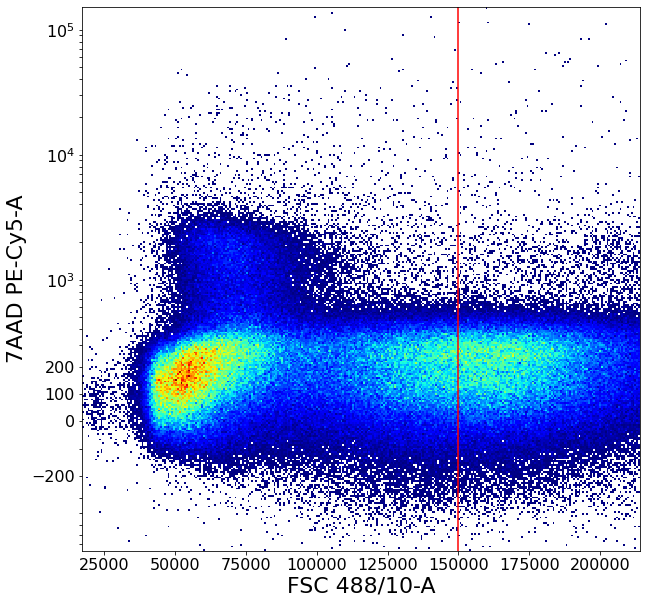

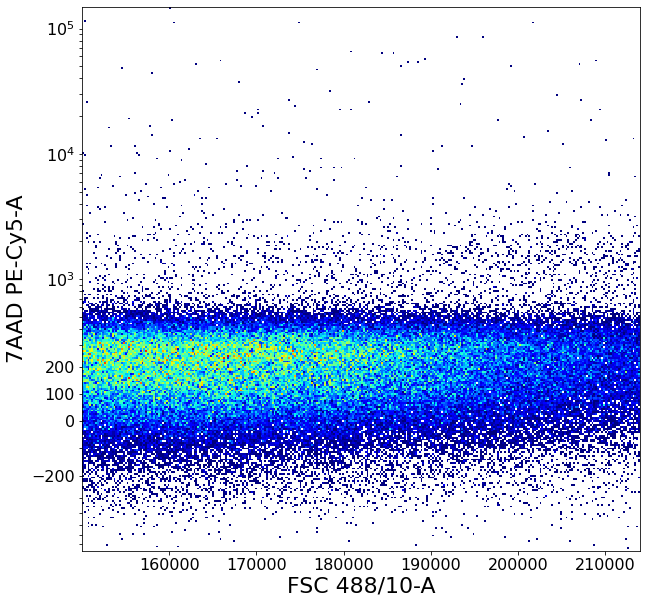

After gating, 139410 out of 447202 events remain.


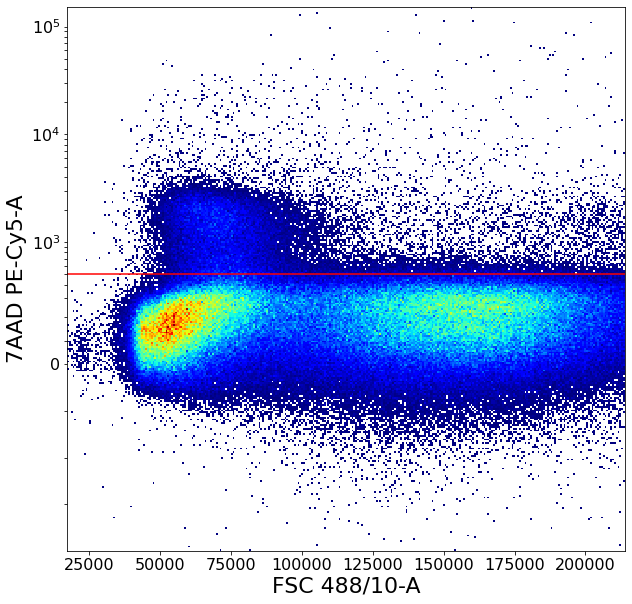

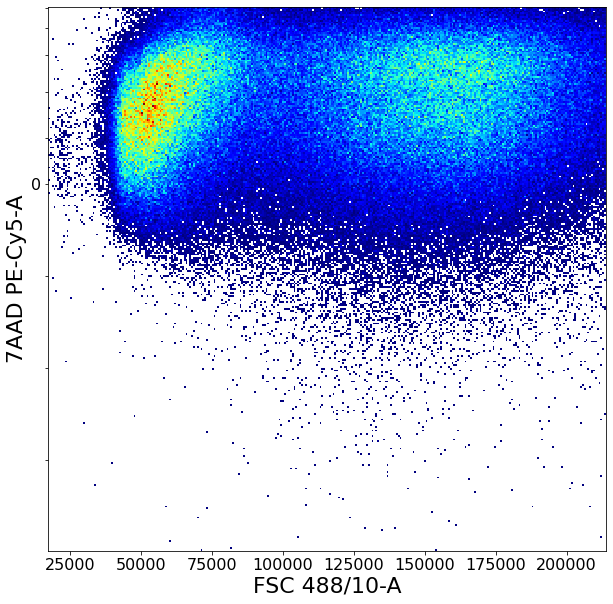

After gating, 410335 out of 447202 events remain.


In [8]:
## Gate 1:  Viable/non-viable separation through 7AAD
livedead_step1 = ag.gateThreshold(my_sample, name="remove_clutter", xCol='FSC 488/10-A', yCol= marker_7AAD, scale='linear', T=200, yscale='bilog', thresh=214000, parentGate=None, orientation='vertical', population='lower')
livedead_step2 = ag.gateThreshold(my_sample, name="remove_clutter", xCol='FSC 488/10-A', yCol= marker_7AAD, scale='linear', T=200, yscale='bilog', thresh=-800, parentGate=livedead_step1, orientation='horizontal', population='upper')   
halfcut = ag.gateThreshold(my_sample, name="remove_clutter", xCol='FSC 488/10-A', yCol= marker_7AAD, scale='linear', T=200, yscale='bilog', thresh=150000, parentGate=livedead_step2, orientation='vertical', population='upper')    
ylim_back = ag.densityDelimitation(my_sample, xCol= marker_7AAD, parentGate=halfcut, interval=[300,1100], limit_threshold=0.2, direction='right',scale='bilog',T=200)    
if ylim_back == inf:  # Failsafe in case of no limit
    ylim_back = 900    
  
livedead_final = ag.gateThreshold(my_sample, name="Viable", xCol='FSC 488/10-A', yCol= marker_7AAD, scale='linear', T=200, yscale='logicle', thresh=ylim_back, parentGate=livedead_step2, orientation='horizontal', population='lower')

## Gate 2:  Singlets

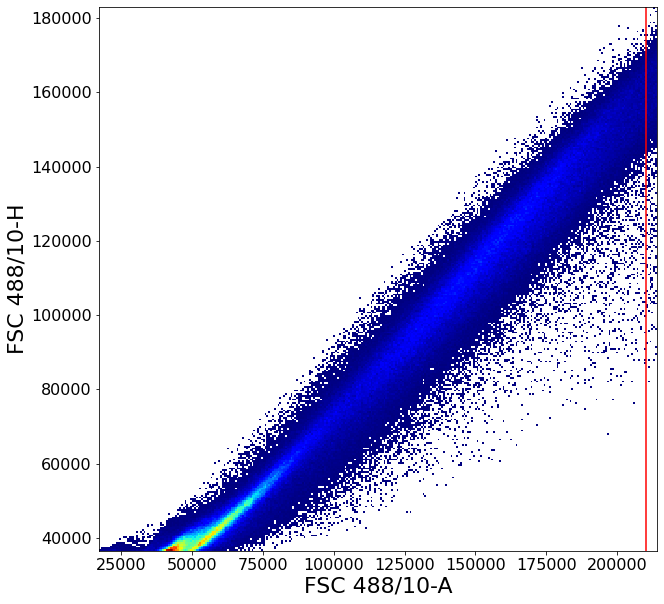

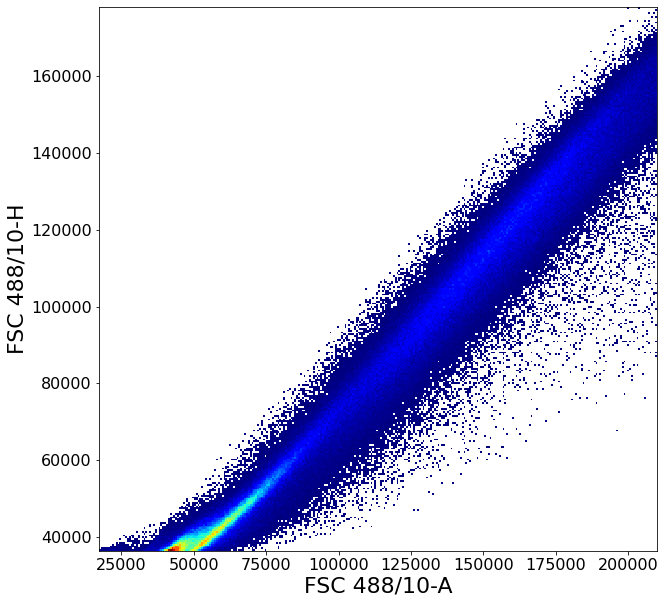

After gating, 406620 out of 410335 events remain.
After gating, 400751 out of 406620 events remain.


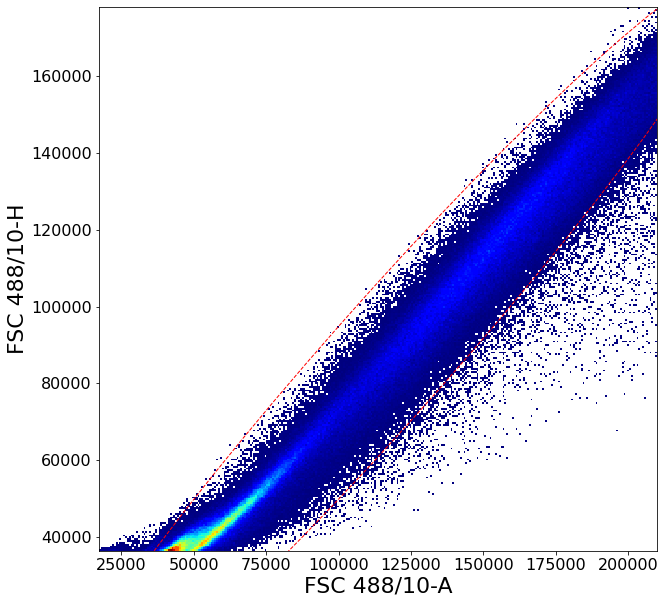

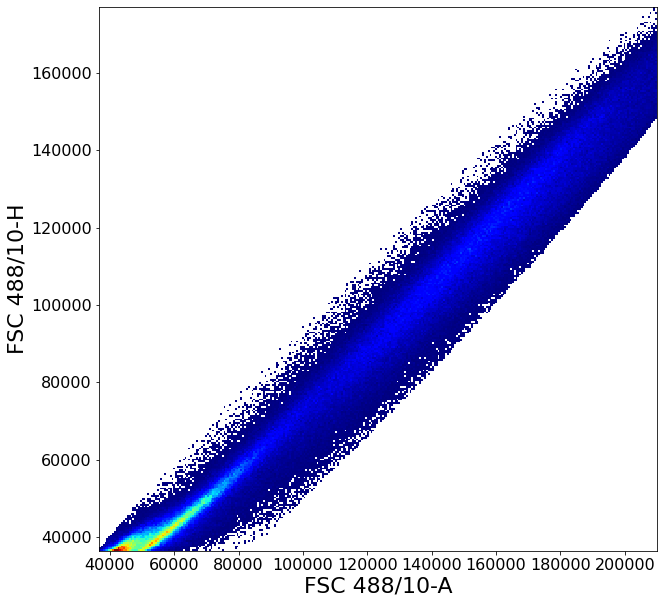

<Figure size 720x720 with 0 Axes>

In [9]:
## Gate 2:  Singlets
singlets_step1 = ag.gateThreshold(my_sample, name="remove_high_clutter", xCol='FSC 488/10-A', yCol='FSC 488/10-H', scale='linear', thresh=210000, parentGate=livedead_final,  orientation='vertical', population='lower')
singlets = ag.gatePC(my_sample, name="Singlets", xCol='FSC 488/10-A', yCol='FSC 488/10-H', center='centroid', adjustAngle=3,widthScale=2.5,heightScale=3.5, parentGate=singlets_step1)

## Gate 3: CBMC cells  

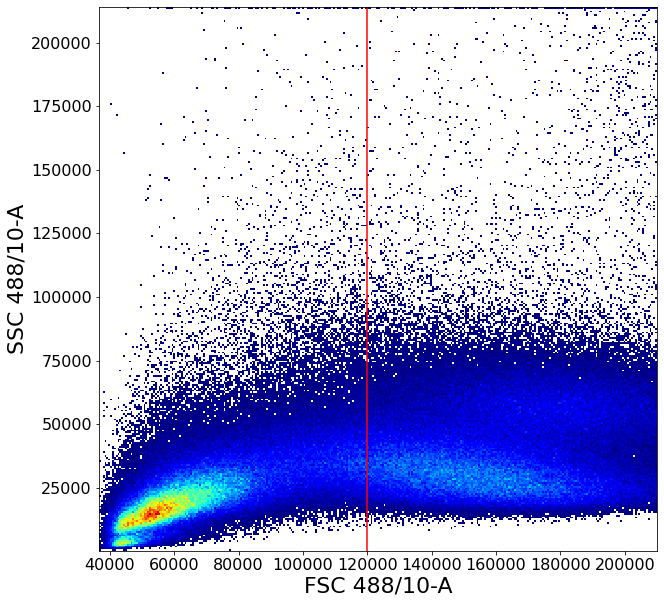

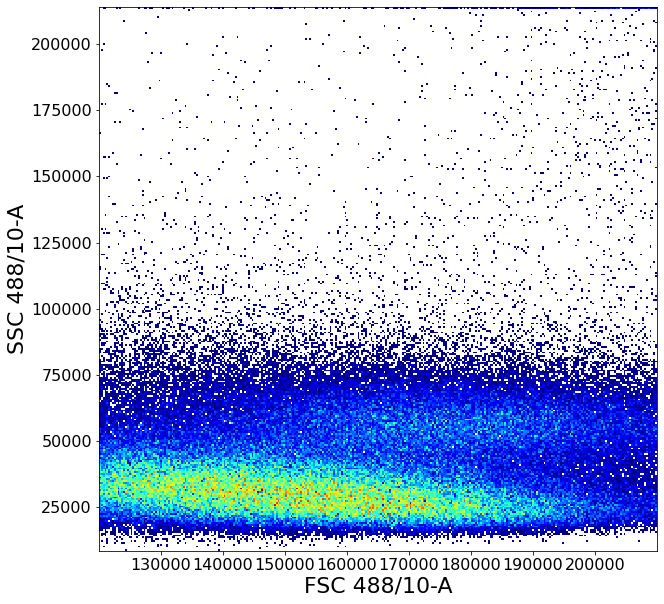

After gating, 201174 out of 400751 events remain.
/home/antton/Programs/aligater/aligater/AGPlotRoutines.py:201: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  cmap.set_bad(color='white') #Zeroes should be white, not blue


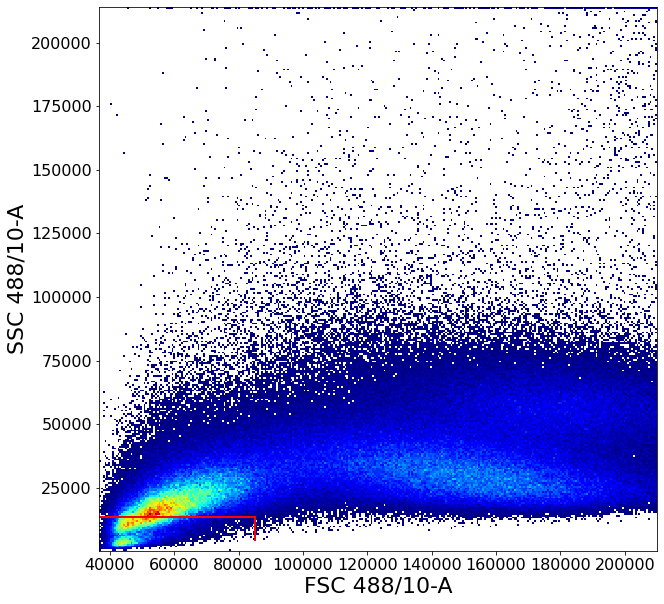

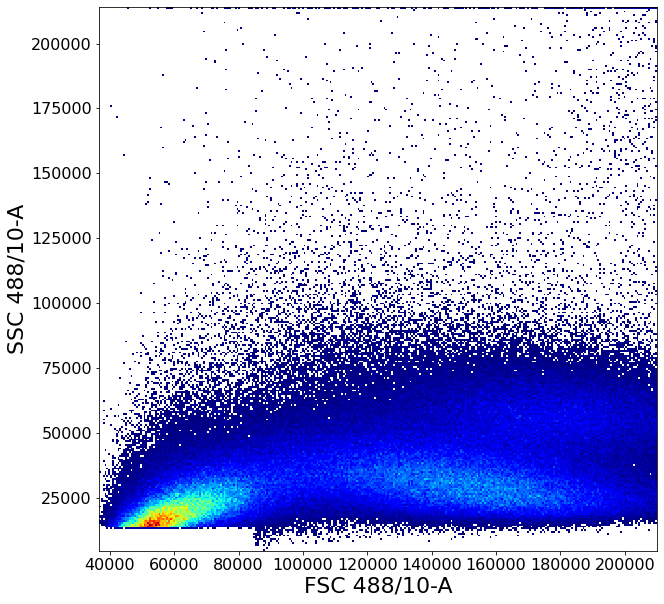

After gating, 367376 out of 400751 events remain.


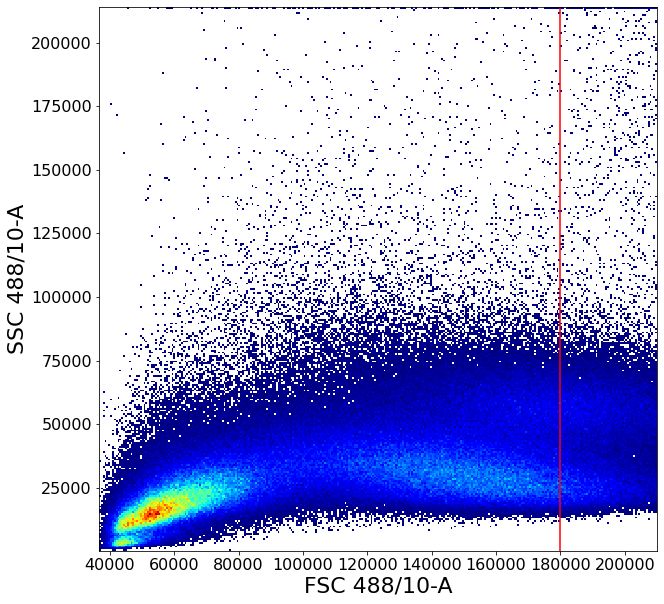

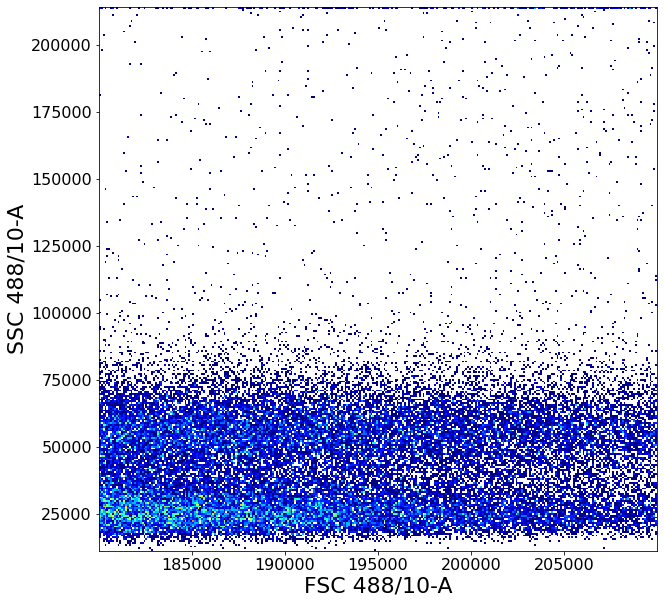

After gating, 47311 out of 400751 events remain.


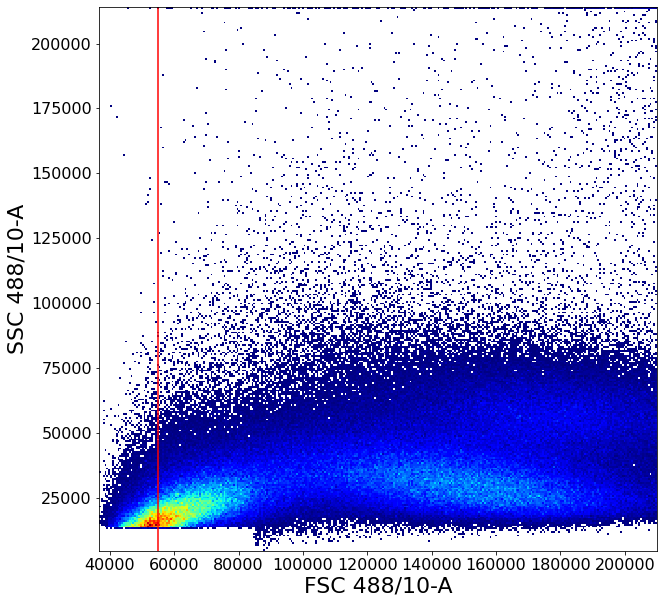

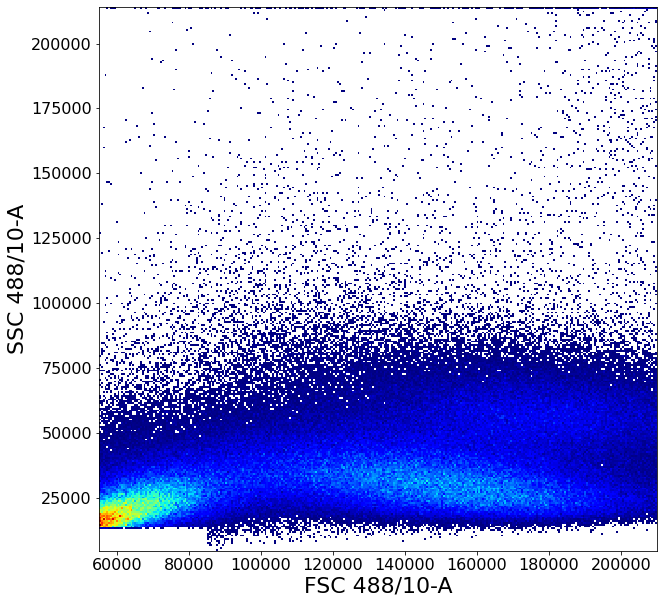

After gating, 343440 out of 367376 events remain.


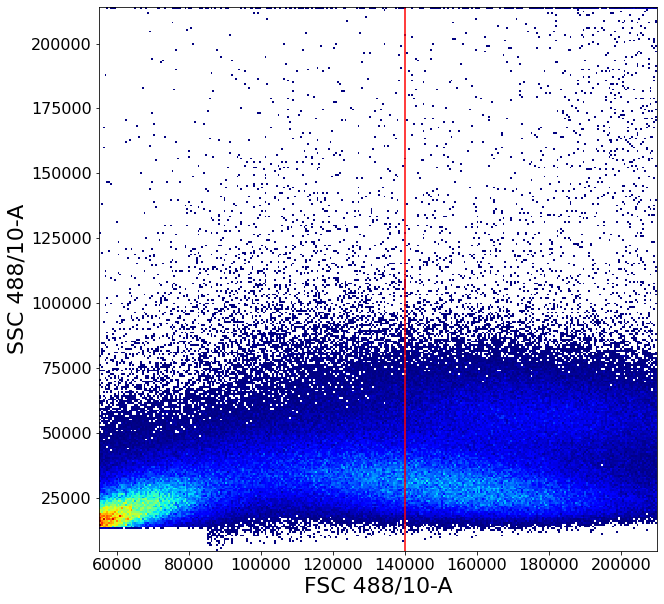

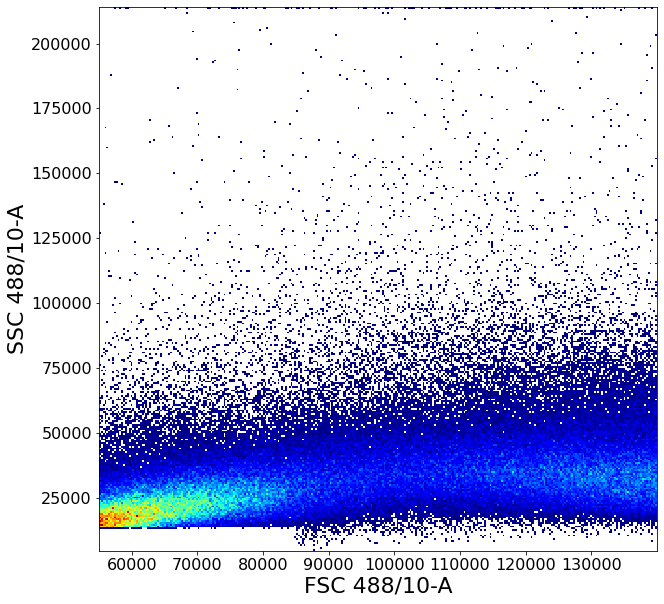

After gating, 188367 out of 343440 events remain.


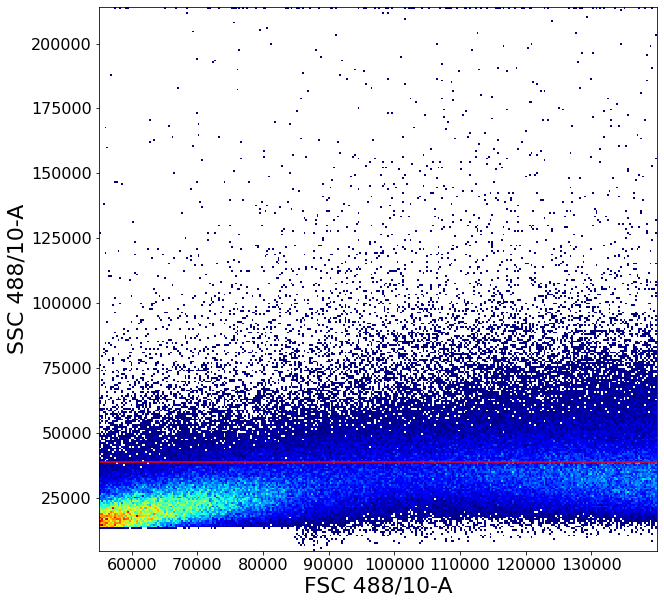

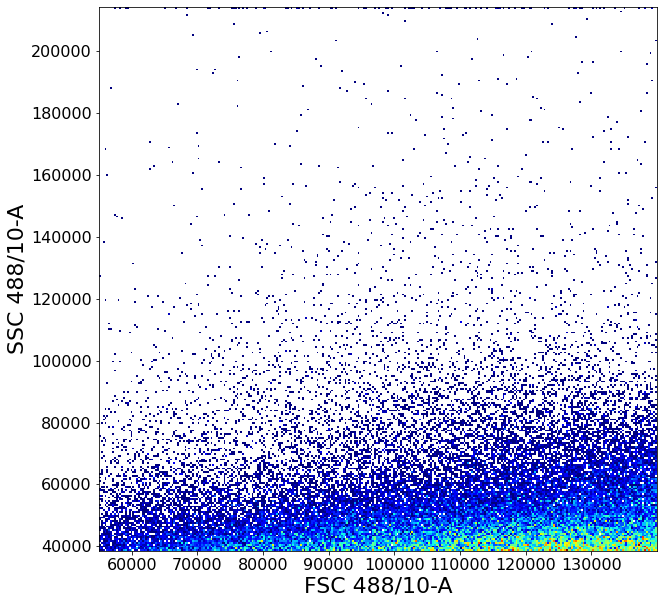

After gating, 52928 out of 188367 events remain.


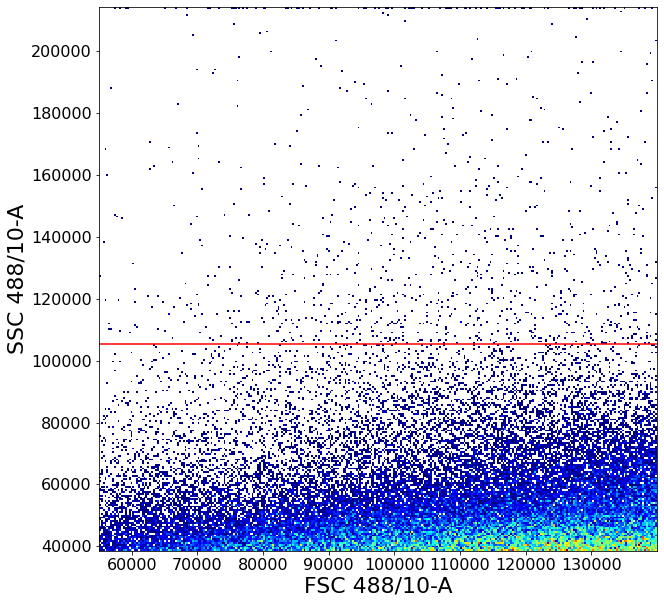

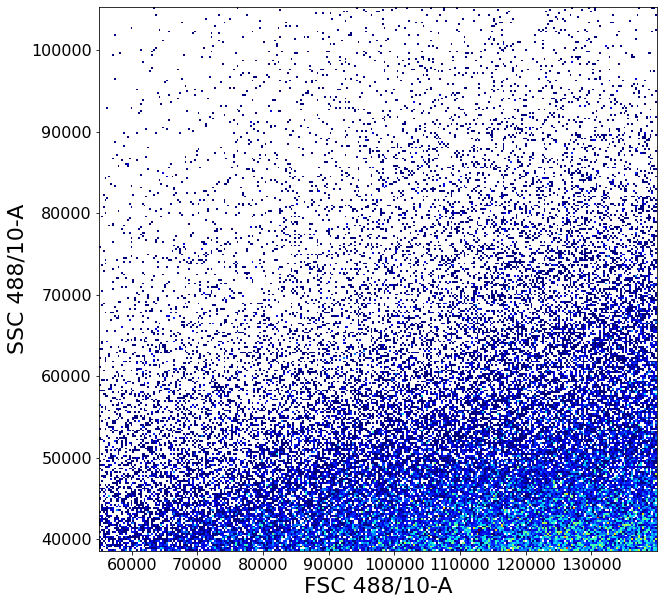

After gating, 51892 out of 52928 events remain.
After gating, 362305 out of 51892 events remain.
/tmp/ipykernel_79395/3542598780.py:15: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  CBMC = ag.horizontalPath(my_sample, name="CBMC",


<Figure size 720x720 with 0 Axes>

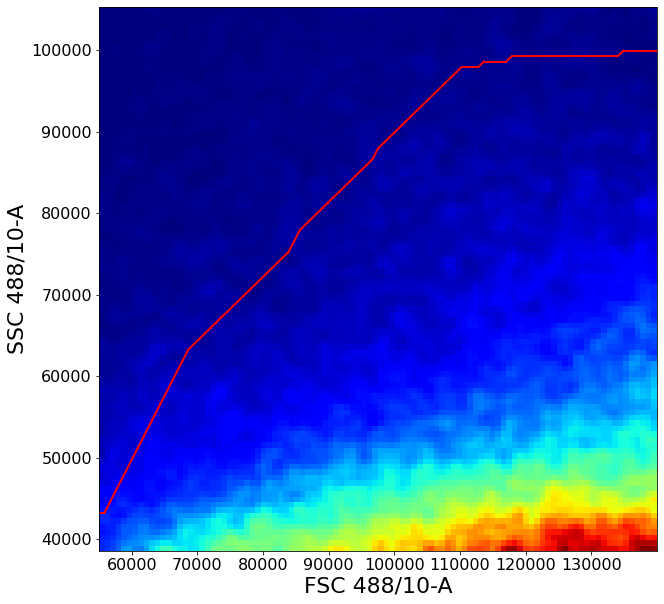

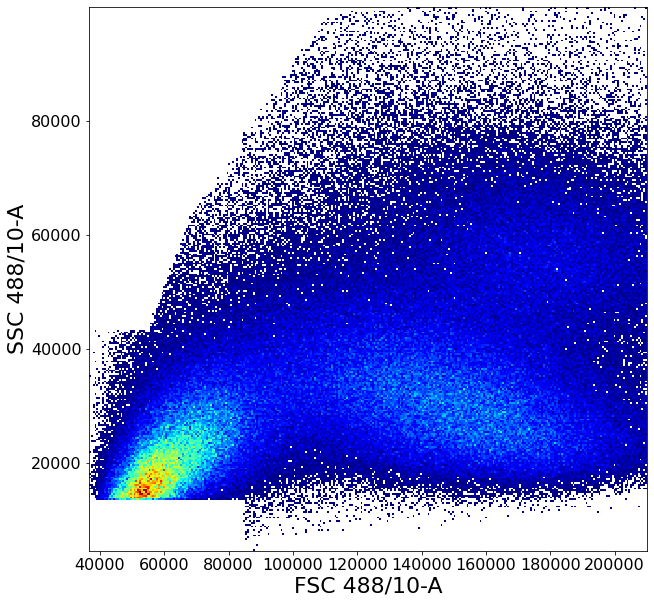

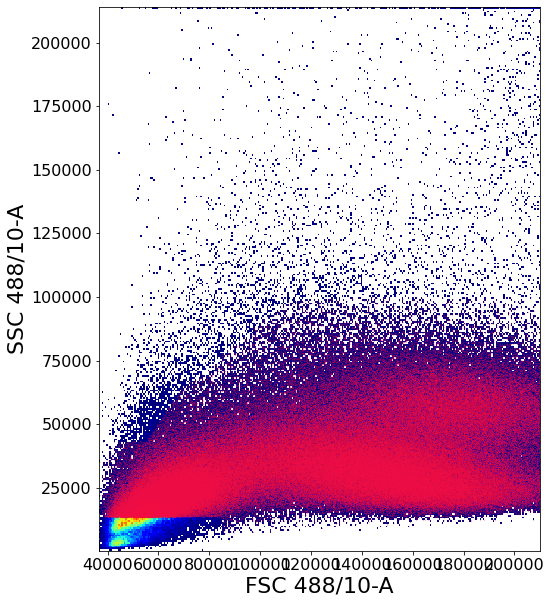

In [10]:
## Gate 3: CBMC cells  

halfcut_middle = ag.gateThreshold(my_sample, name="right_tail", xCol='FSC 488/10-A', yCol='SSC 488/10-A', scale='linear', thresh=120000, parentGate=singlets, orientation='vertical', population='upper')

ylim_bot = ag.densityDelimitation(my_sample, xCol='SSC 488/10-A', parentGate=halfcut_middle, interval=[10000,20000], limit_threshold=0.05, direction='left',scale='linear')
if ylim_bot == inf:
    ylim_bot = 10000
CBMC_step1 = ag.gateCorner(my_sample, name="cut_corner", xCol='FSC 488/10-A', yCol='SSC 488/10-A', xThresh=85000, yThresh=ylim_bot, xOrientation='lower', yOrientation='lower', Outer=True, parentGate=singlets)

halfcut_tail = ag.gateThreshold(my_sample, name="right_tail",  xCol='FSC 488/10-A', yCol='SSC 488/10-A', scale='linear', thresh=180000, parentGate=singlets, orientation='vertical', population='upper')
ylim_top = ag.densityDelimitation(my_sample, xCol='SSC 488/10-A', parentGate=halfcut_tail, interval=[50000, 125000], limit_threshold=0.2, direction='right',scale='linear') + 25000
if ylim_top == inf:
    ylim_top = 140000

CBMC = ag.horizontalPath(my_sample, name="CBMC",
                    xCol='FSC 488/10-A', yCol='SSC 488/10-A', population='lower',
                    startY=ylim_bot+30000, endY=ylim_top, xboundaries=[55000,140000],
                    yboundaries=[ylim_bot+25000,ylim_top+5000],
                    leftRight=True , direction='both',
                    maxStep=2, phi=0.1, bins=100, sigma=1,
                    scale='linear', parentGate=CBMC_step1)


ag.backGate(my_sample, population=CBMC, background_population=singlets, xCol='FSC 488/10-A', yCol='SSC 488/10-A', scale='linear', T=200, markersize=0.1)

my_sample.update(ag.AGgate(CBMC, None,'FSC 488/10-A', 'SSC 488/10-A', "CBMC"), QC=True, scale='linear',xlim=[25000,180000], ylim=[0,200000])


## Gate 4: CD45+ AND CD34+ out of CBMC cells, "Declutter gate" to get rid of CD45- debree 

/home/antton/Programs/aligater/aligater/AGPlotRoutines.py:201: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  cmap.set_bad(color='white') #Zeroes should be white, not blue


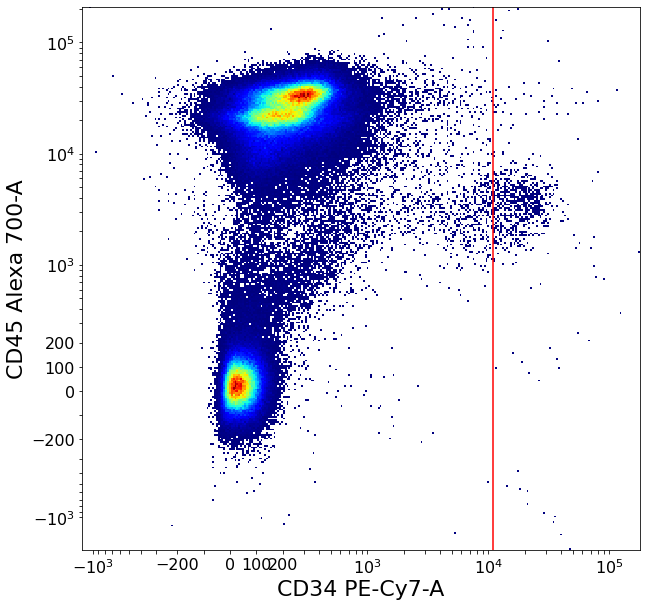

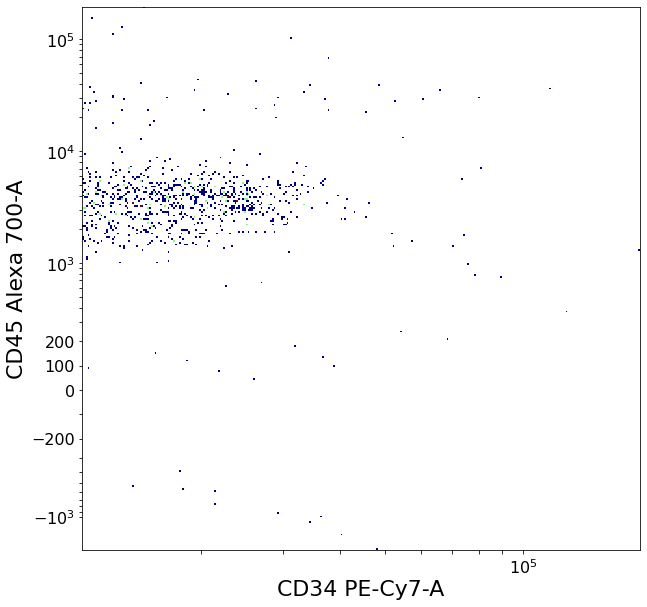

After gating, 845 out of 362305 events remain.


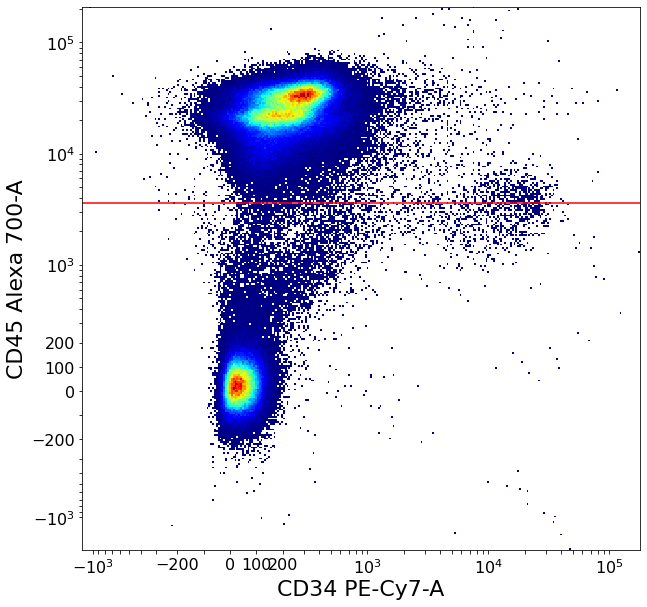

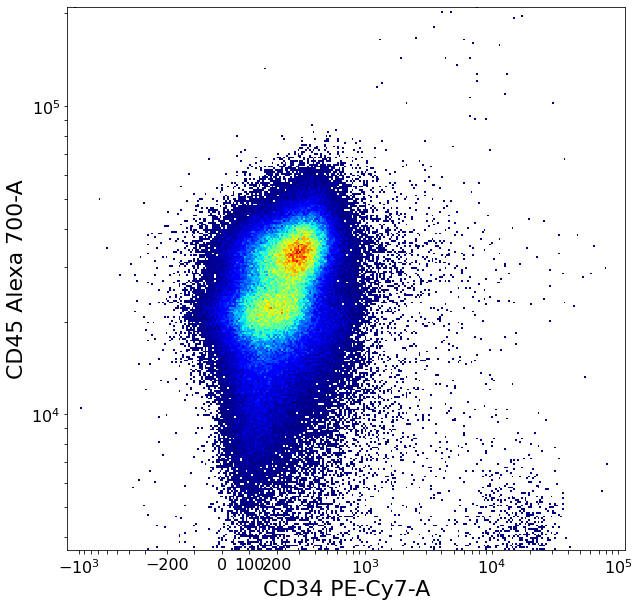

After gating, 246170 out of 362305 events remain.


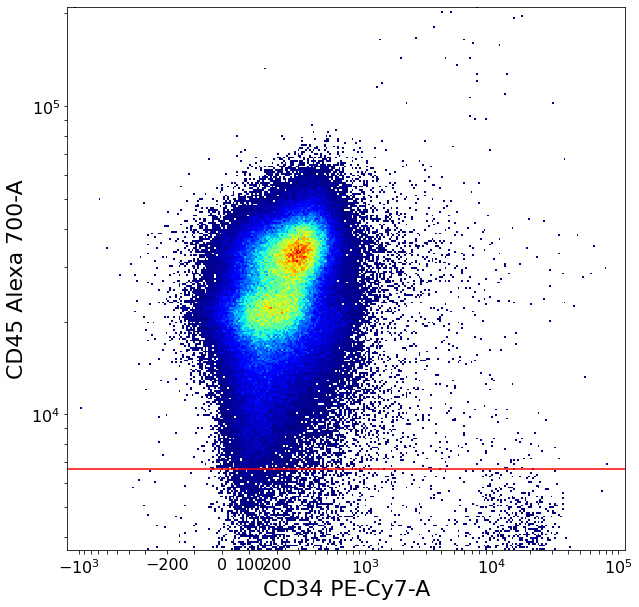

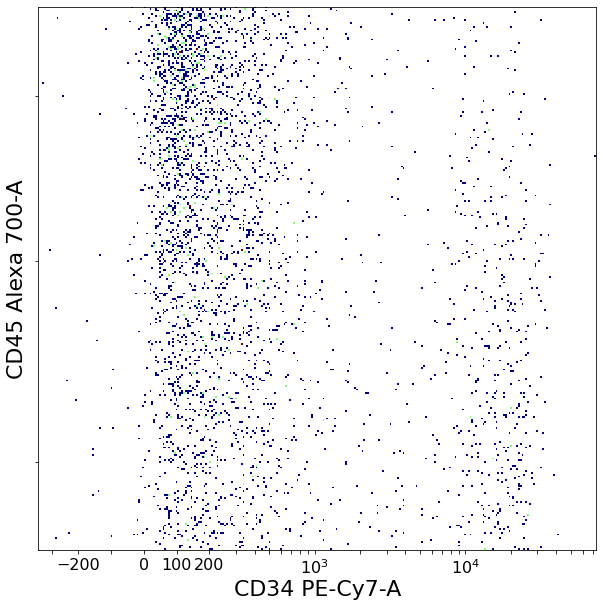

After gating, 3349 out of 246170 events remain.


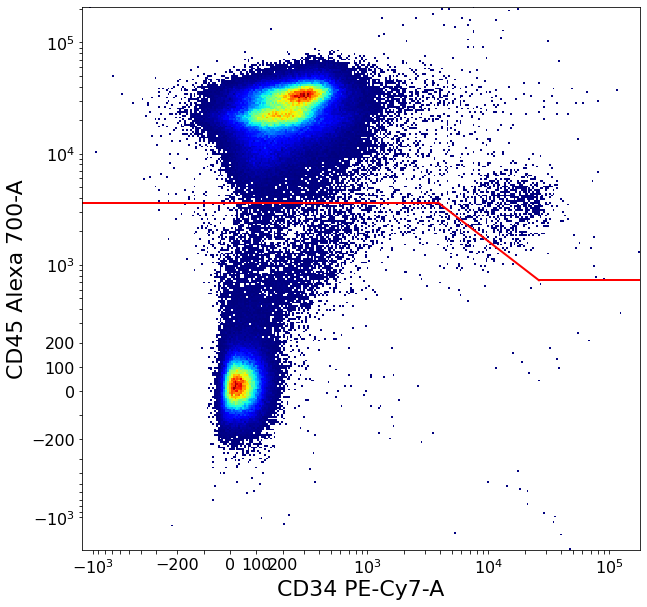

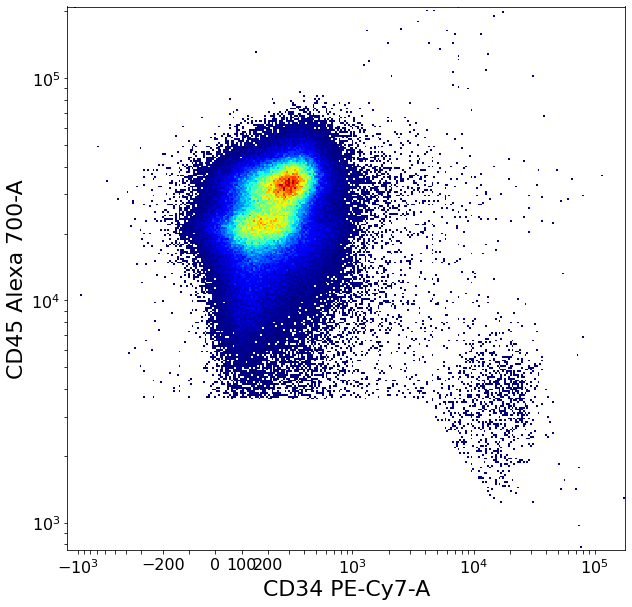

In [11]:
## Gate 4: CD45+ AND CD34+ out of CBMC cells, "Declutter gate" to get rid of CD45- debree 
xlim_arbitrary = 11000
right_half = ag.gateThreshold(my_sample, name="right_half", xCol='CD34 PE-Cy7-A' , yCol=CD45, scale='bilog', T=200, thresh=xlim_arbitrary, parentGate=CBMC, orientation='vertical', population='upper')    
    # Get highest density point of CD34 blob to use as reference
mean, median, sigma, maxVal = ag.axisStats(my_sample(), xCol=CD45, vI=right_half())
upper_half = ag.gateThreshold(my_sample, name="upper_half", xCol='CD34 PE-Cy7-A', yCol=CD45, scale='bilog', T=200, thresh=maxVal, parentGate=CBMC, orientation='horizontal', population='upper')    
lowr_halfof_upper_half = ag.gateThreshold(my_sample, name="lower_half_of_upper_half", xCol='CD34 PE-Cy7-A', yCol=CD45, scale='bilog', T=200, thresh=maxVal+3000, parentGate=upper_half, orientation='horizontal', population='lower')   
xlim_middle = ag.valleySeek(my_sample, xCol='CD34 PE-Cy7-A', interval=[800, 11000], require_local_min=True, scale='bilog', T=200, parentGate=lowr_halfof_upper_half) -1000        

CD45_high = ag.gateTiltedLine(my_sample, name="CD45+", xCol='CD34 PE-Cy7-A' , yCol=CD45, startPoint=(xlim_middle,maxVal), endLimits=(None, maxVal-2900), theta=-40, scale='bilog', T=200, population='upper', parentGate=CBMC)


## Gate 5: CD34+ ratio relative to CD45+

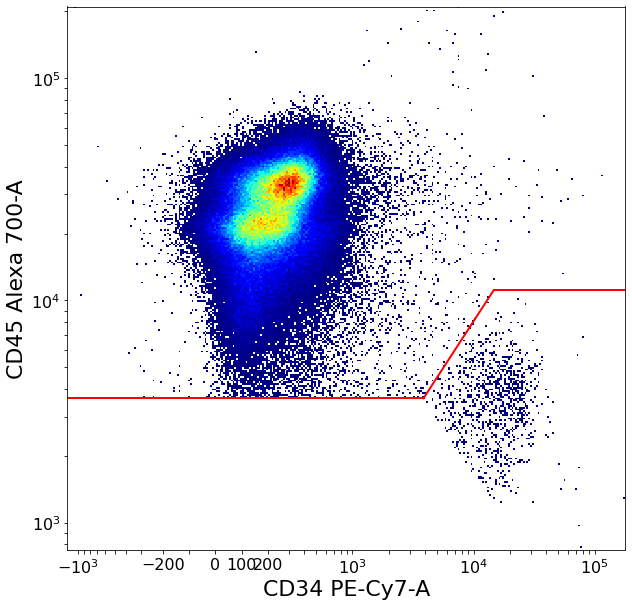

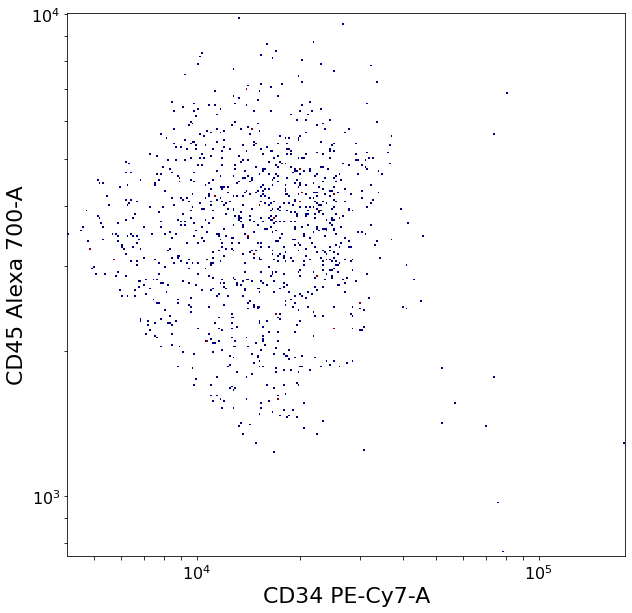

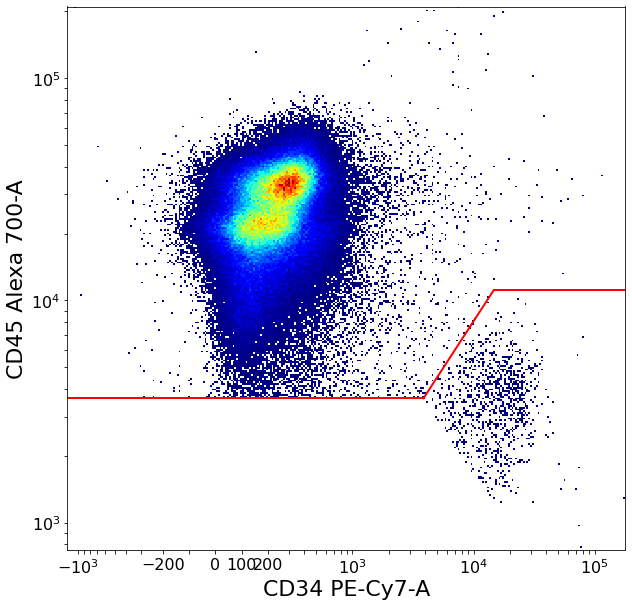

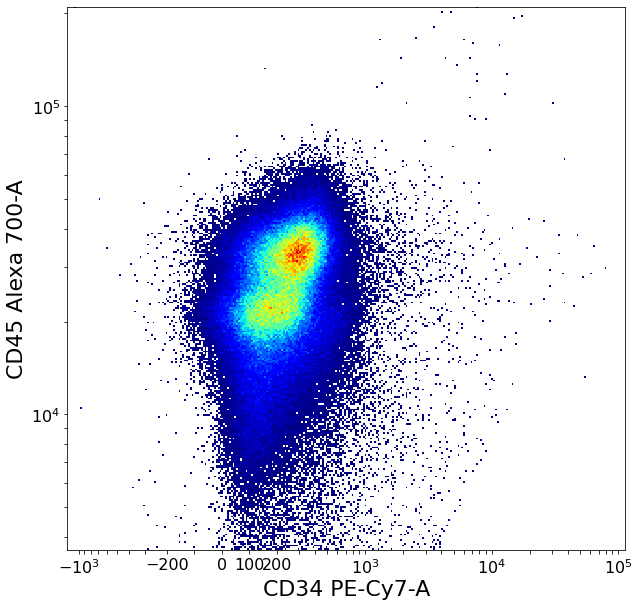

In [12]:
## Gate 5: CD34+ ratio relative to CD45+
CD34pos = ag.gateTiltedLine(my_sample, name="CD34+", xCol='CD34 PE-Cy7-A' , yCol=CD45, startPoint=(xlim_middle,maxVal), endLimits=(None, maxVal+7500), theta=40, scale='bilog', T=200, population='lower', parentGate=CD45_high)

CD45pos = ag.gateTiltedLine(my_sample, name="CD45+", xCol='CD34 PE-Cy7-A' , yCol=CD45, startPoint=(xlim_middle,maxVal), endLimits=(None, maxVal+7500), theta=40, scale='bilog', T=200, population='upper', parentGate=CD45_high)

my_sample.update(ag.AGgate(CD34pos, CD45pos,'CD34 PE-Cy7-A', CD45, "CD34+"), QC=True, scale='bilog', xscale='bilog', yscale='bilog', T=200, xlim=[-1000, 100000], ylim=[1000, 150000])


## Gate 6: CD3 out of CD45+

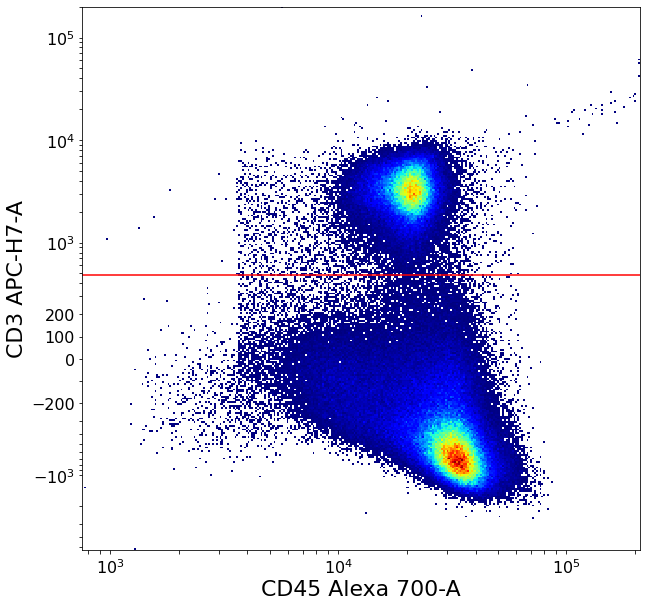

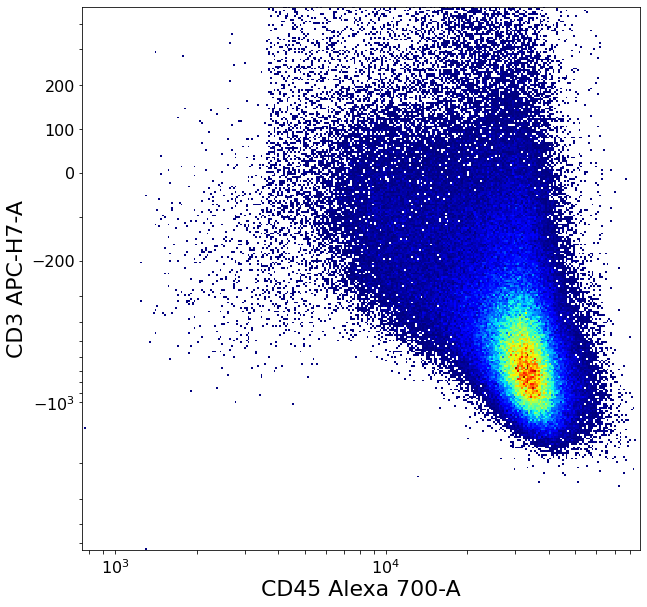

After gating, 168512 out of 246694 events remain.


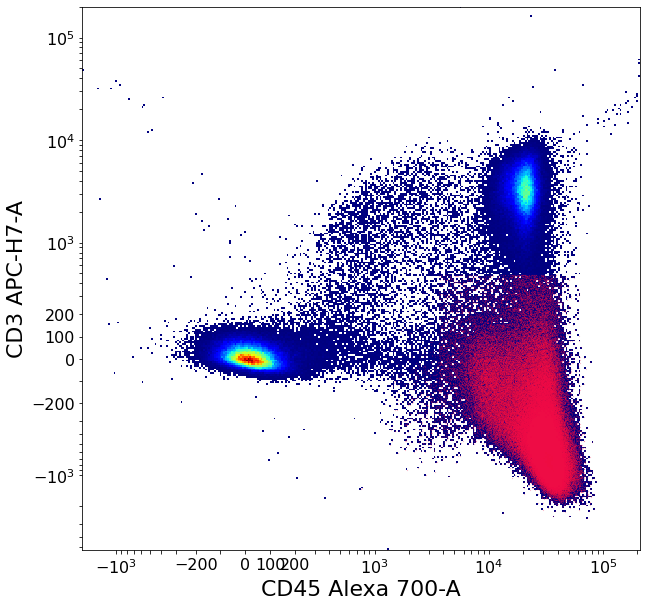

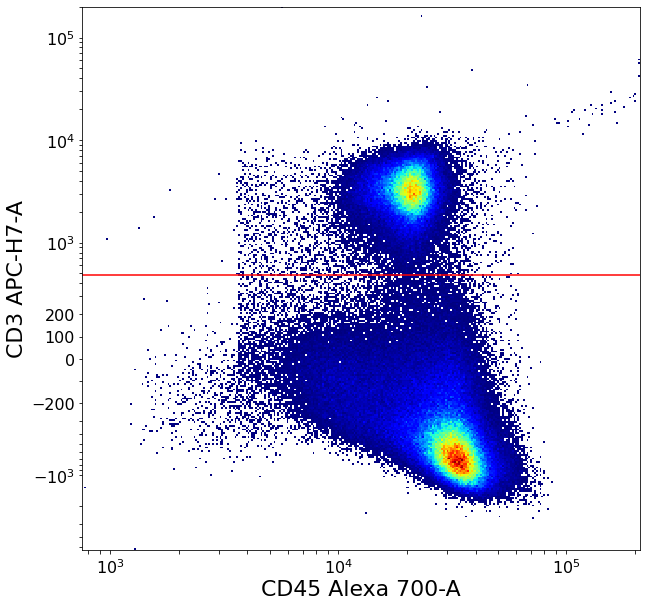

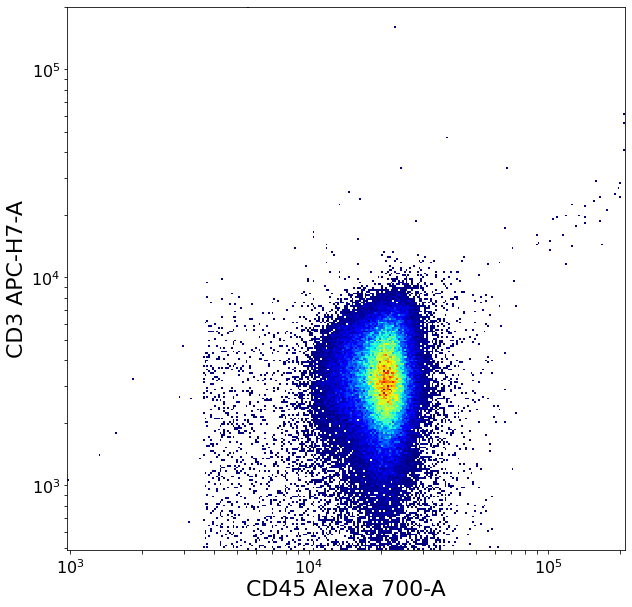

After gating, 78182 out of 246694 events remain.


In [13]:
## Gate 6: CD3 out of CD45+
    ## Gate 6A: CD3-        
ylim_middle = ag.valleySeek(my_sample, xCol='CD3 APC-H7-A', interval=[-1000, 7000], require_local_min=True, scale='bilog', T=200, parentGate=CD45_high)    
CD3neg = ag.gateThreshold(my_sample, name="CD3-", xCol=CD45 , yCol='CD3 APC-H7-A', scale='bilog', T=200, thresh=ylim_middle, parentGate=CD45_high, orientation='horizontal', population='lower')    

ag.backGate(my_sample, population=CD3neg, background_population=CBMC, xCol=CD45 , yCol='CD3 APC-H7-A', scale='bilog', T=200, markersize=0.1)  
    ## Gate 6B: CD3+ 
CD3pos = ag.gateThreshold(my_sample, name="CD3+", xCol=CD45 , yCol='CD3 APC-H7-A', scale='bilog', T=200, thresh=ylim_middle, parentGate=CD45_high, orientation='horizontal', population='upper')

my_sample.update(ag.AGgate(CD3pos, CD45pos, CD45, 'CD3 APC-H7-A', "CD3+"), QC=False)


## Gate 7: CD4, CD8 out of CD3+

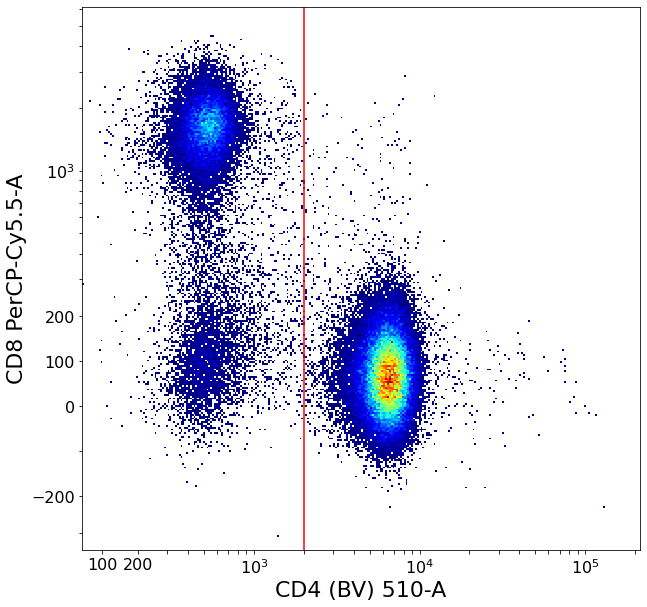

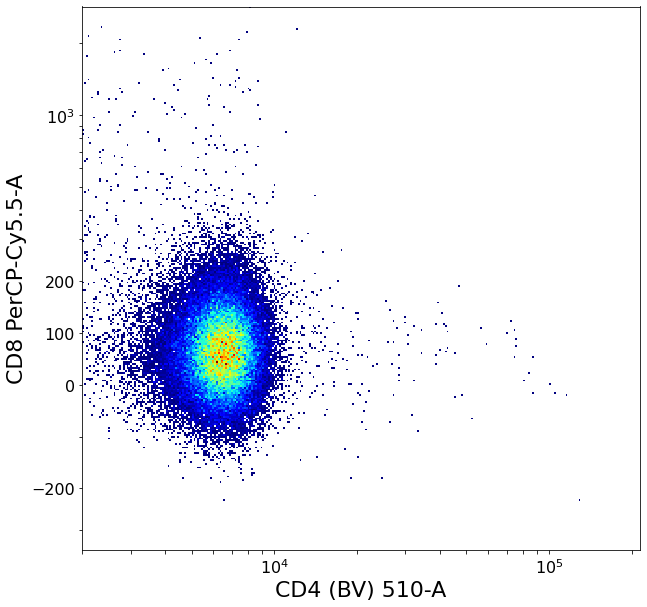

After gating, 54688 out of 78182 events remain.
After gating, 53258 out of 54688 events remain.


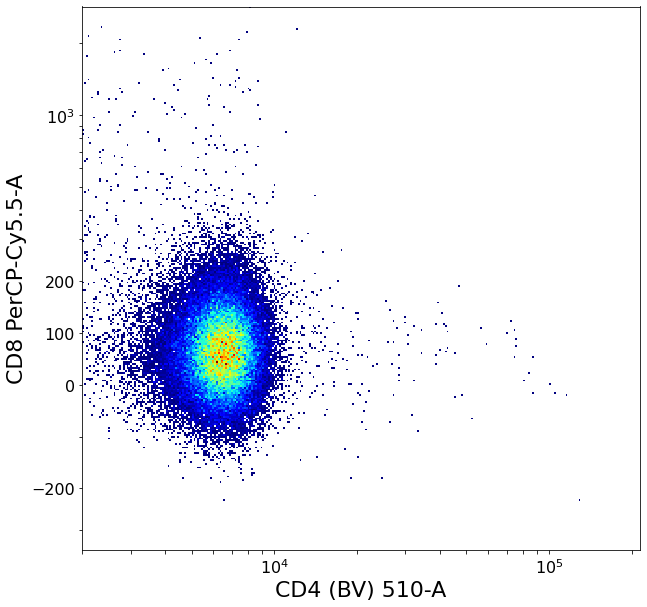

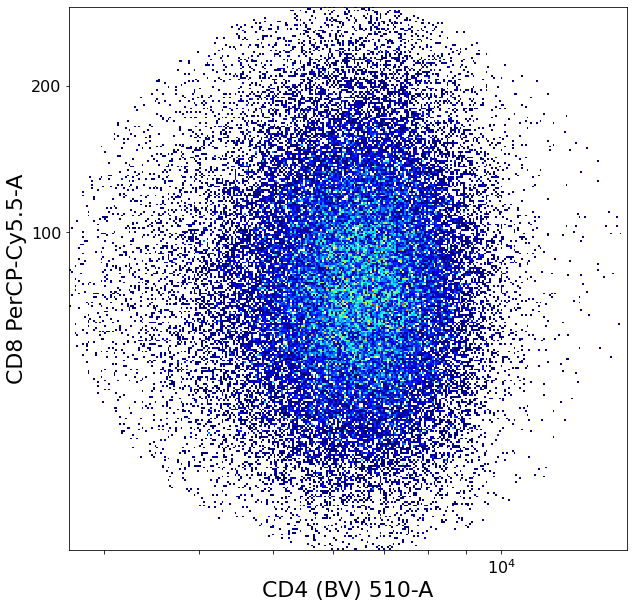

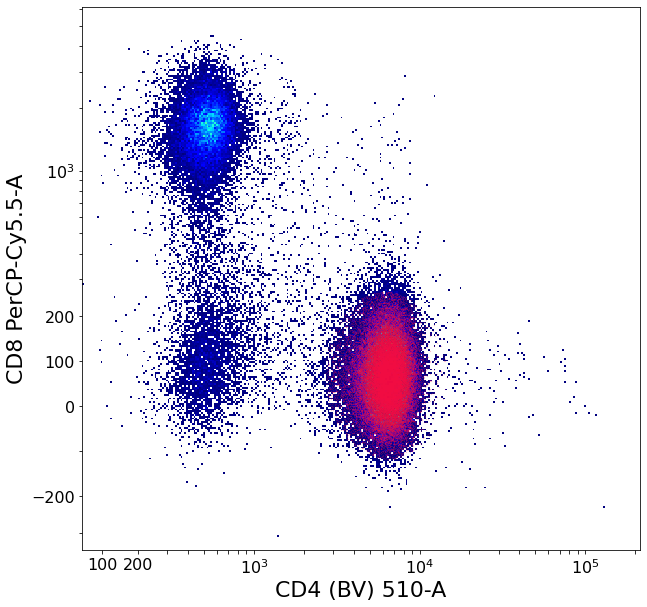

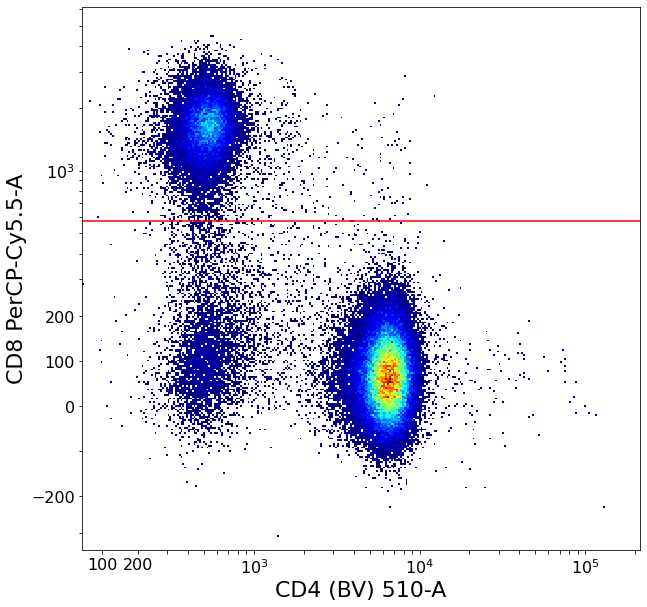

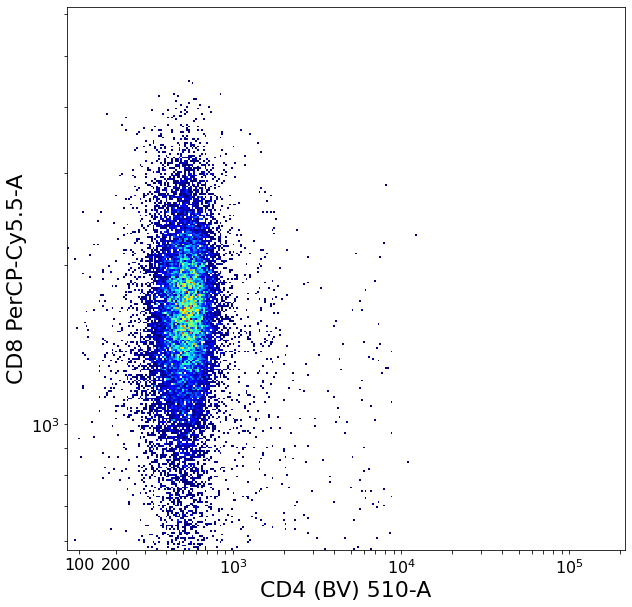

After gating, 18082 out of 78182 events remain.


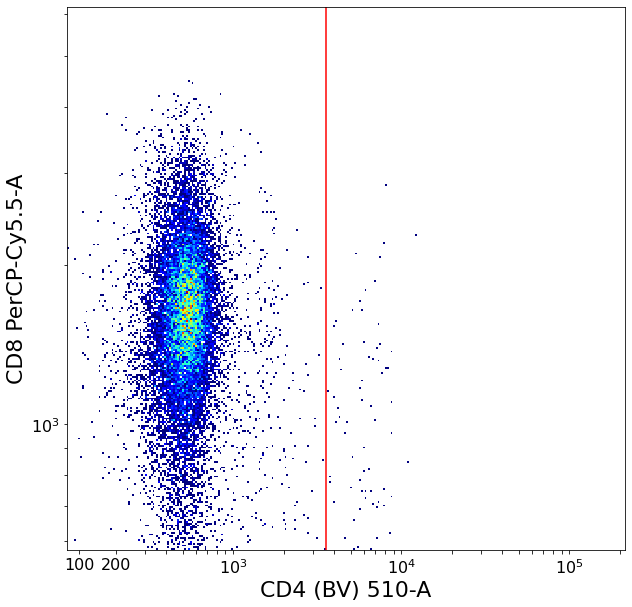

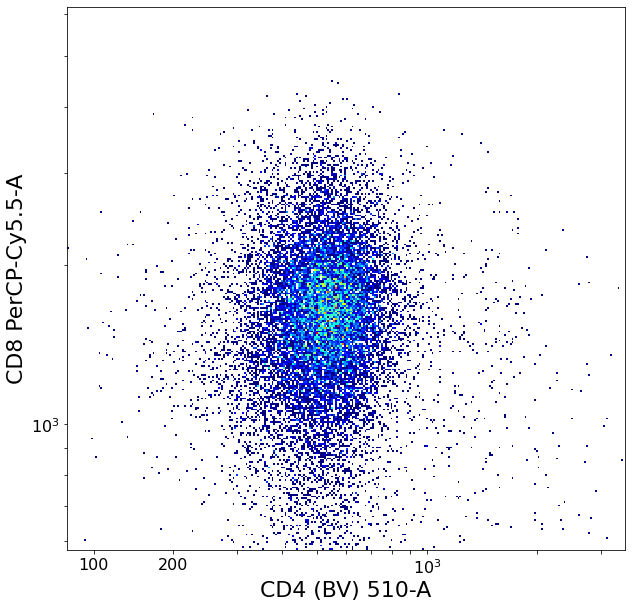

After gating, 18013 out of 18082 events remain.
After gating, 16555 out of 18013 events remain.


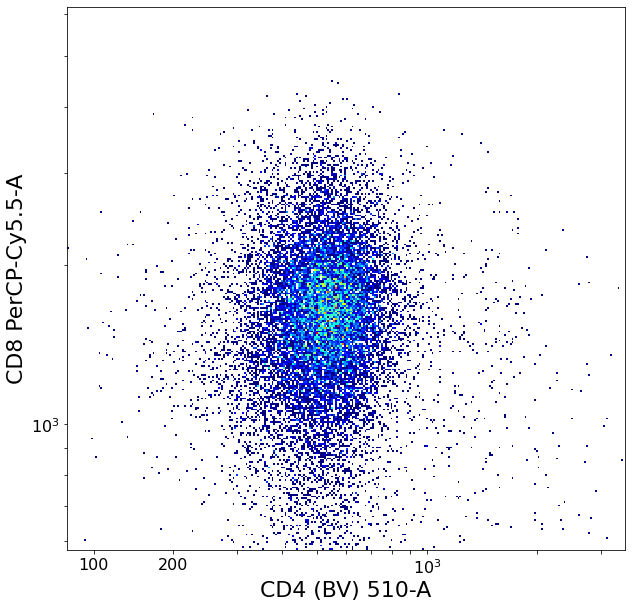

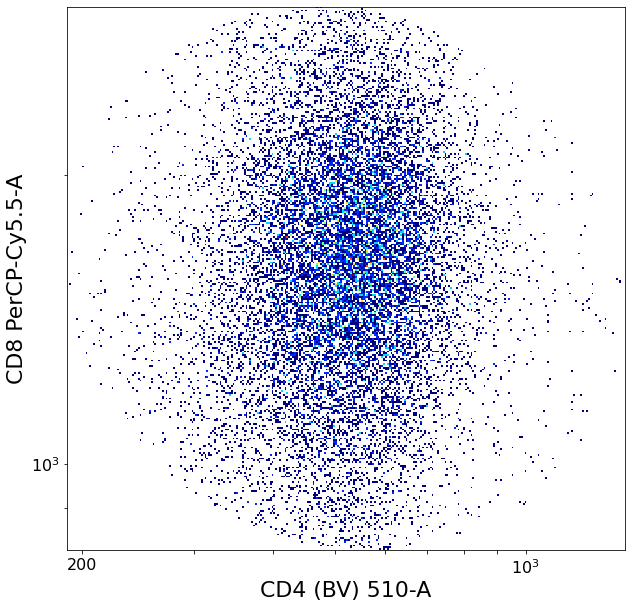

<Figure size 720x720 with 0 Axes>

In [14]:
##Gate 7: CD4, CD8 out of CD3+
    ## Gate 7A: CD4+
xlim_middle = ag.valleySeek(my_sample, xCol='CD4 (BV) 510-A', interval=[1000, 5000], require_local_min=True, scale='bilog', T=200, parentGate=CD3pos)
cd4cd8_step1 = ag.gateThreshold(my_sample, name="separate_middle", xCol='CD4 (BV) 510-A' , yCol='CD8 PerCP-Cy5.5-A', scale='bilog', T=200, thresh=xlim_middle, parentGate=CD3pos, orientation='vertical', population='upper')    
CD4pos_final = ag.gatePC(my_sample, name="CD4+", xCol='CD4 (BV) 510-A' , yCol='CD8 PerCP-Cy5.5-A', center='centroid', adjustAngle=3,widthScale=2.5, scale='bilog', T=200, heightScale=3.5, parentGate=cd4cd8_step1)    

ag.backGate(my_sample, population=CD4pos_final, background_population=CD3pos, xCol='CD4 (BV) 510-A' , yCol='CD8 PerCP-Cy5.5-A', scale='bilog', T=200, markersize=0.1) 

my_sample.update(ag.AGgate(CD4pos_final, CD3pos,'CD4 (BV) 510-A','CD8 PerCP-Cy5.5-A',"CD4+_1"), QC=False)
    ##Gate 7B: CD8+
ylim_middle = ag.valleySeek(my_sample, xCol='CD8 PerCP-Cy5.5-A', interval=[200, 2000], require_local_min=True, parentGate=CD3pos)
cd4cd8_step2 = ag.gateThreshold(my_sample, name="separate_middle", xCol='CD4 (BV) 510-A' , yCol='CD8 PerCP-Cy5.5-A', scale='bilog', T=200, thresh=ylim_middle, parentGate=CD3pos, orientation='horizontal', population='upper')    
xlim_middle_upper = ag.valleySeek(my_sample, xCol='CD4 (BV) 510-A', interval=[1000, 5000], require_local_min=True, scale='bilog', T=200, parentGate=cd4cd8_step2)   
cd4cd8_step3 = ag.gateThreshold(my_sample, name="separate_middle_x_axis", xCol='CD4 (BV) 510-A' , yCol='CD8 PerCP-Cy5.5-A', scale='bilog', T=200, thresh=xlim_middle_upper, parentGate=cd4cd8_step2, orientation='vertical', population='lower')   
CD8pos_final = ag.gatePC(my_sample, name="CD8+", xCol='CD4 (BV) 510-A' , yCol='CD8 PerCP-Cy5.5-A', center='centroid', adjustAngle=0,widthScale=2, scale='bilog', T=200, heightScale=3.5, parentGate=cd4cd8_step3)

my_sample.update(ag.AGgate(CD8pos_final, CD3pos,'CD4 (BV) 510-A','CD8 PerCP-Cy5.5-A',"CD8+"), QC=False)
my_sample.update(ag.AGgate(CD4pos_final, CD8pos_final,'CD4 (BV) 510-A','CD8 PerCP-Cy5.5-A',"CD4+_2"), QC=False)


## Gate 8: CD19 out of CD3-

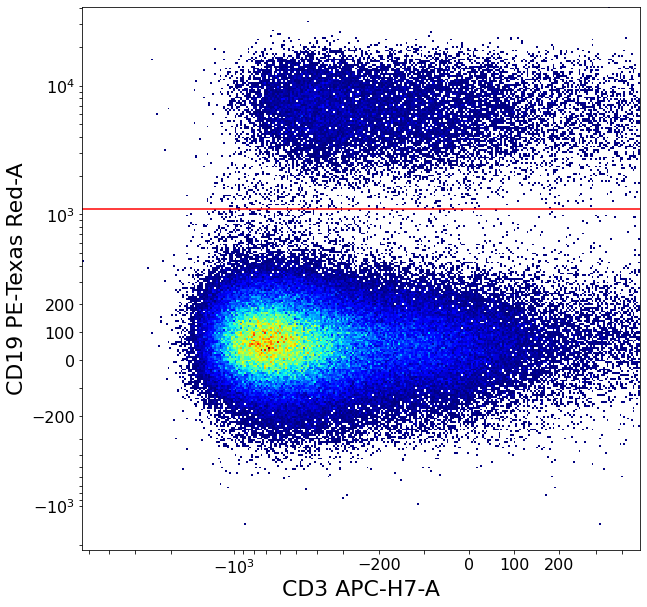

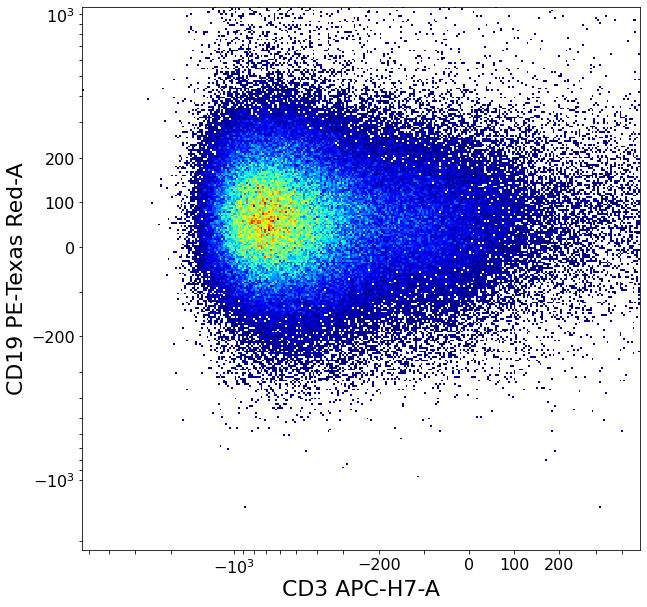

After gating, 149126 out of 168512 events remain.


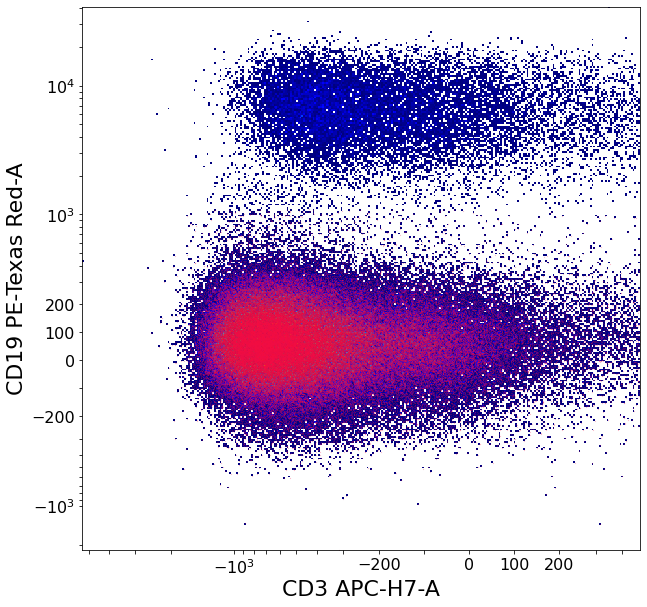

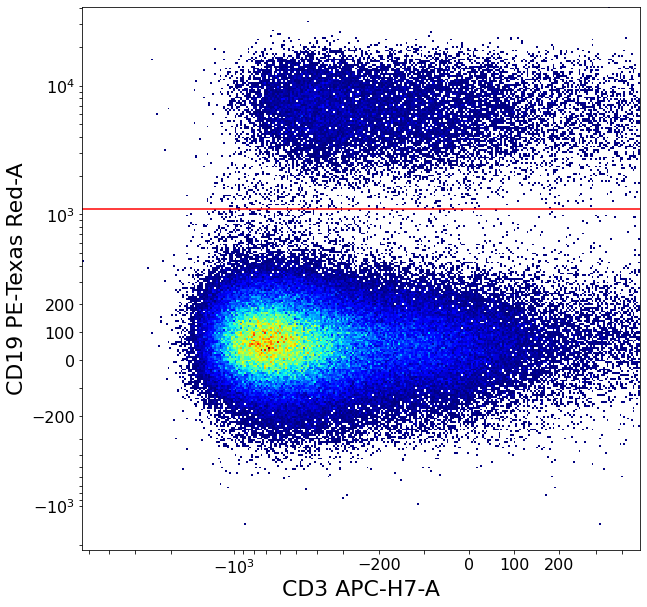

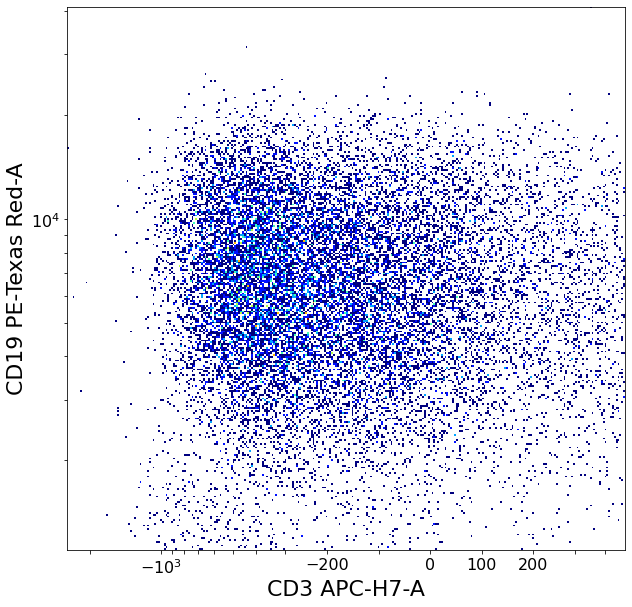

After gating, 19386 out of 168512 events remain.


In [15]:
## Gate 8: CD19 out of CD3-
    ## Gate 8A: CD19-
ylim_middle_cd19 = ag.valleySeek(my_sample, xCol='CD19 PE-Texas Red-A', interval=[200, 10000], require_local_min=True, scale='bilog', T=200, parentGate=CD3neg)
CD19neg = ag.gateThreshold(my_sample, name="CD19-", xCol='CD3 APC-H7-A' , yCol='CD19 PE-Texas Red-A', scale='bilog', T=200, thresh=ylim_middle_cd19, parentGate=CD3neg, orientation='horizontal', population='lower')

ag.backGate(my_sample, population=CD19neg, background_population=CD3neg, xCol='CD3 APC-H7-A'  , yCol='CD19 PE-Texas Red-A', scale='bilog', T=200, markersize=0.1) 
    ## Gate 8B: CD19+
CD19pos = ag.gateThreshold(my_sample, name="CD19+", xCol='CD3 APC-H7-A' , yCol='CD19 PE-Texas Red-A', scale='bilog', T=200, thresh=ylim_middle_cd19, parentGate=CD3neg, orientation='horizontal', population='upper')

my_sample.update(ag.AGgate(CD19pos, CD45pos, 'CD3 APC-H7-A', 'CD19 PE-Texas Red-A', "CD19+"), QC=False)


## Gate 9: CD14 out of CD3-/CD19-    

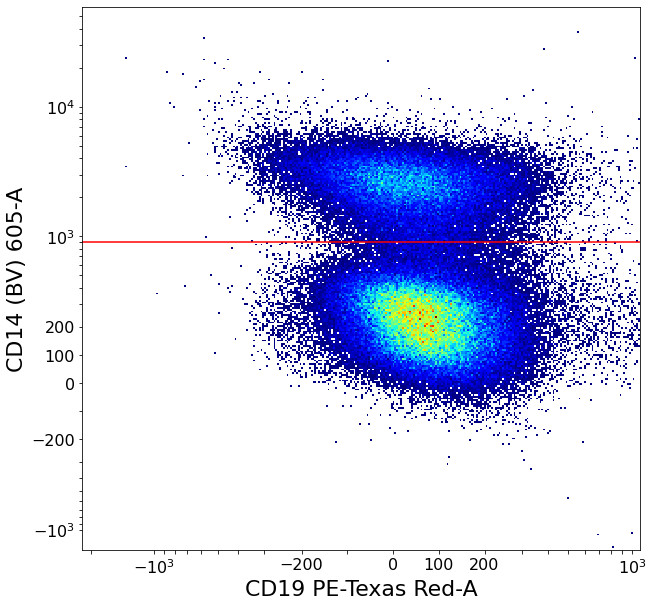

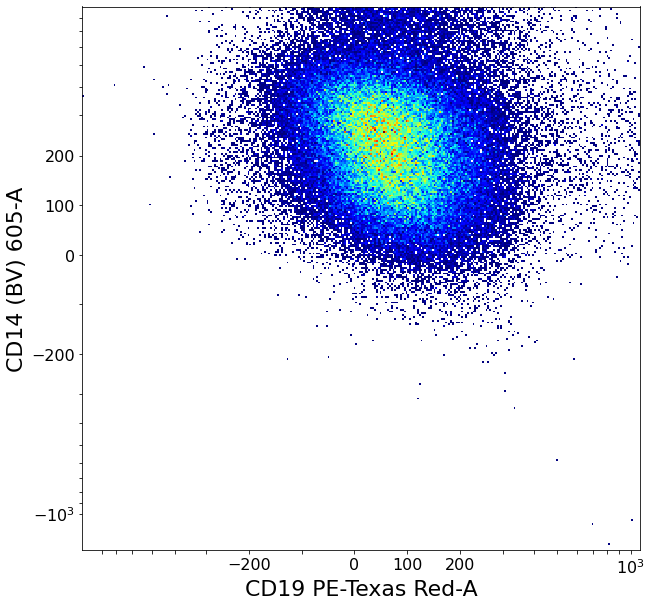

After gating, 100987 out of 149126 events remain.


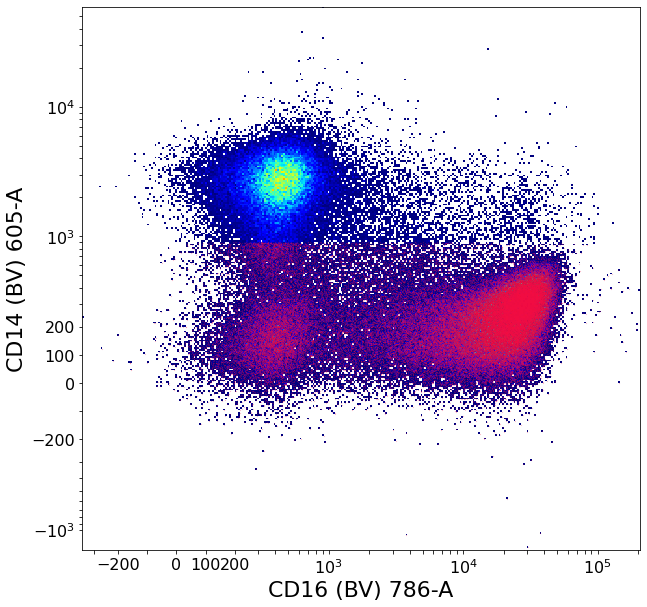

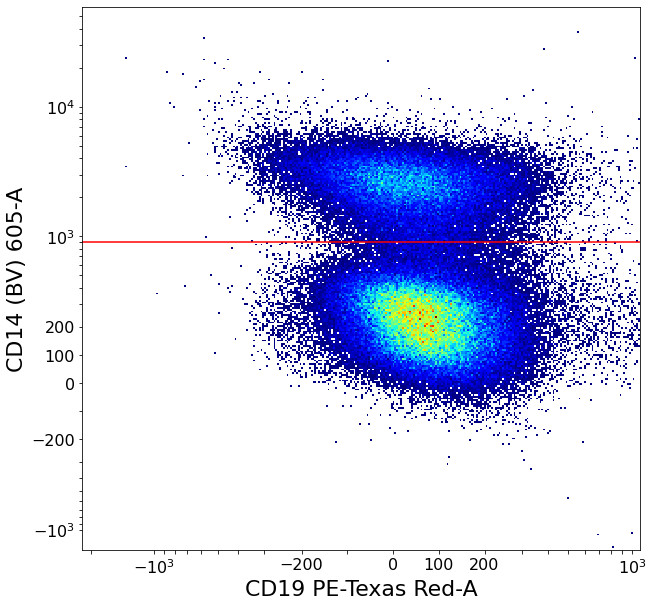

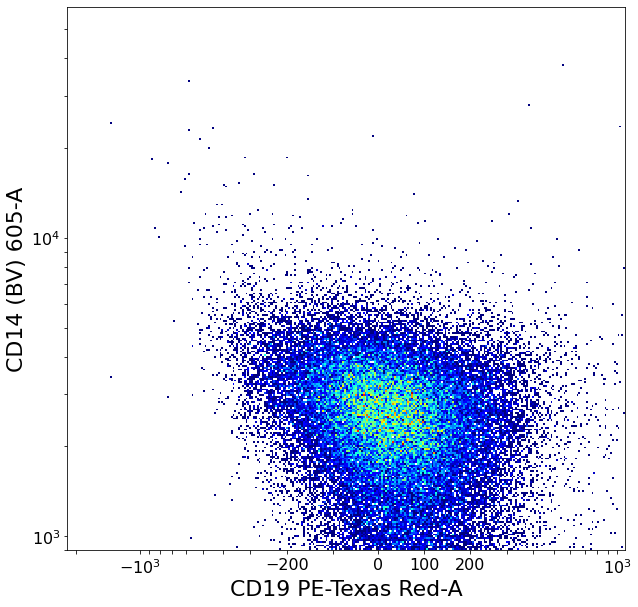

After gating, 48139 out of 149126 events remain.


In [16]:
## Gate 9: CD14 out of CD3-/CD19-    
    ## Gate 7A: CD14- out of CD19-
ylim_middle_cd14 = ag.valleySeek(my_sample, xCol='CD14 (BV) 605-A', interval=[0, 3000], require_local_min=True, parentGate=CD19neg, scale='bilog')
CD14neg = ag.gateThreshold(my_sample, name="CD14-", xCol='CD19 PE-Texas Red-A', yCol='CD14 (BV) 605-A', scale='bilog', T=200, thresh=ylim_middle_cd14, parentGate=CD19neg, orientation='horizontal', population='lower')
ag.backGate(my_sample, population=CD14neg, background_population=CD19neg, xCol='CD16 (BV) 786-A' , yCol='CD14 (BV) 605-A', scale='bilog', T=200, markersize=0.1)     
    ## Gate 7B: CD14+ out of CD19-        
CD14pos = ag.gateThreshold(my_sample, name="CD14+", xCol='CD19 PE-Texas Red-A', yCol='CD14 (BV) 605-A', scale='bilog', T=200, thresh=ylim_middle_cd14, parentGate=CD19neg, orientation='horizontal', population='upper')

my_sample.update(ag.AGgate(CD14pos, CD45pos, 'CD19 PE-Texas Red-A', 'CD14 (BV) 605-A', "CD14+"), QC=False)


## Gate 10: CD16 and CD56 values out of CD14-

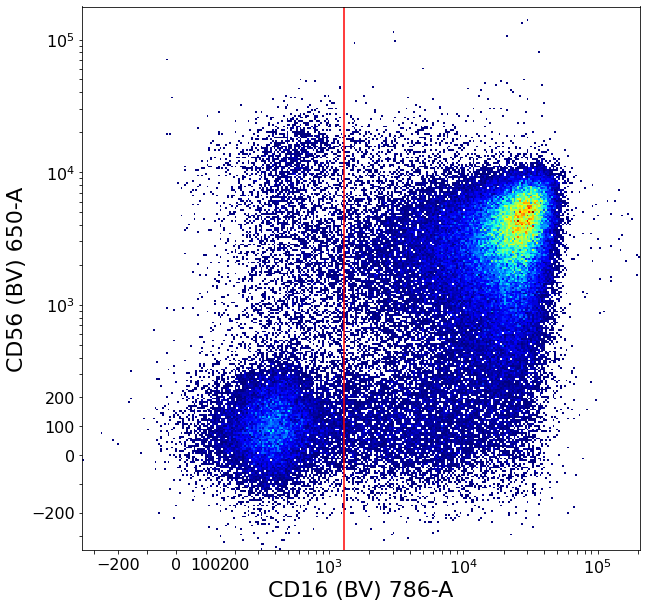

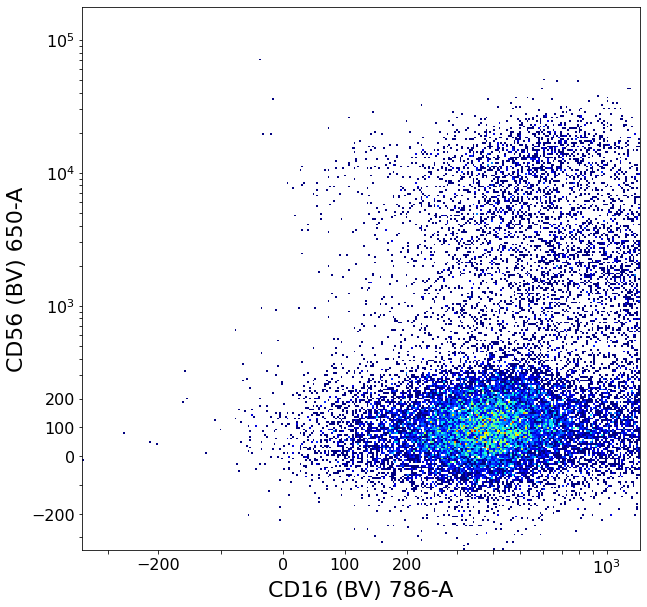

After gating, 22426 out of 100987 events remain.


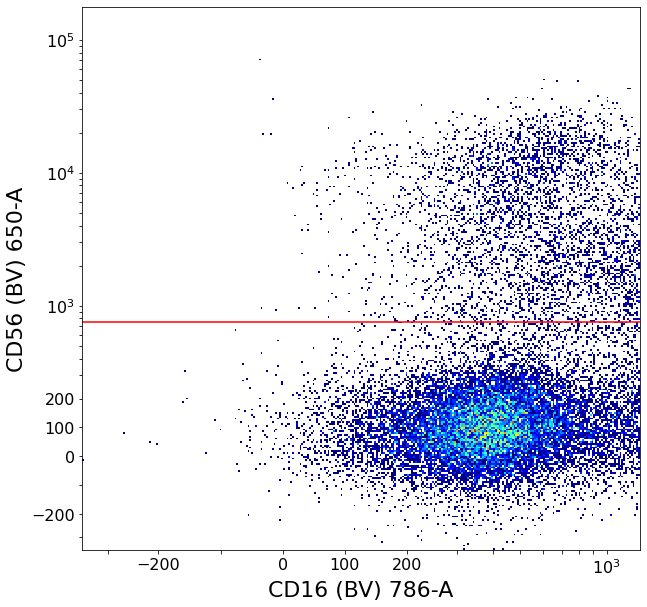

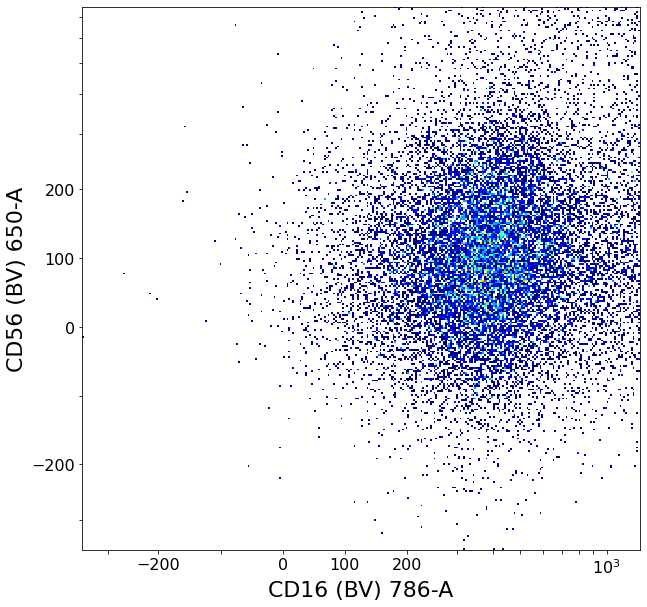

After gating, 18363 out of 22426 events remain.


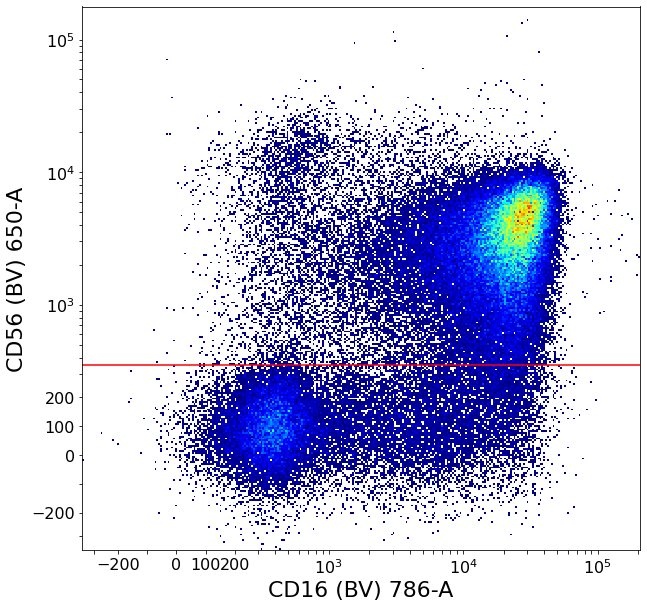

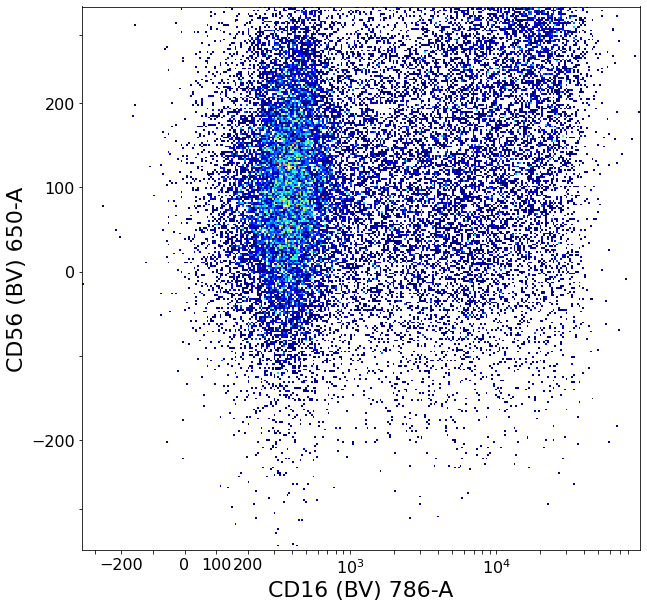

After gating, 28959 out of 100987 events remain.


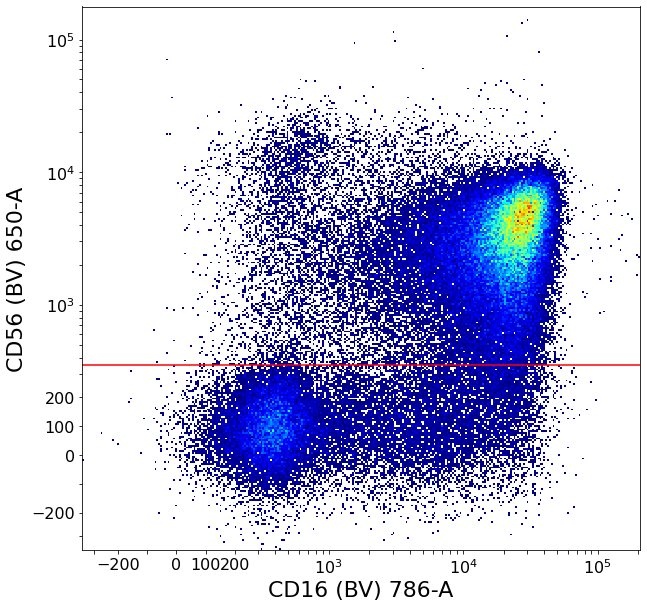

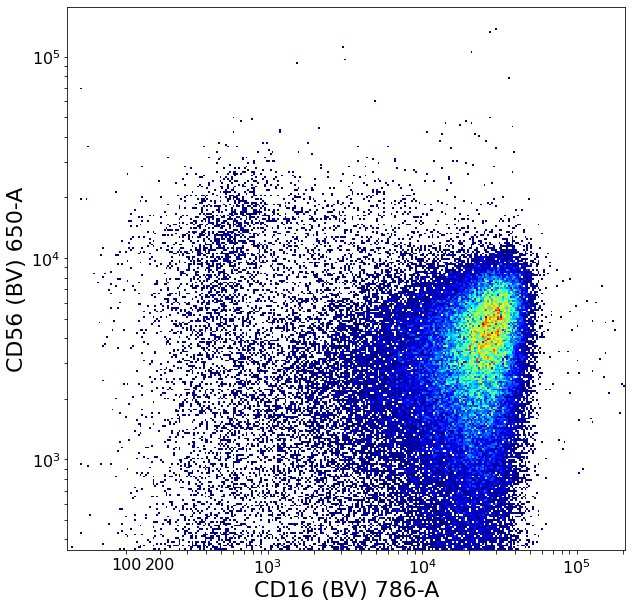

After gating, 72028 out of 100987 events remain.


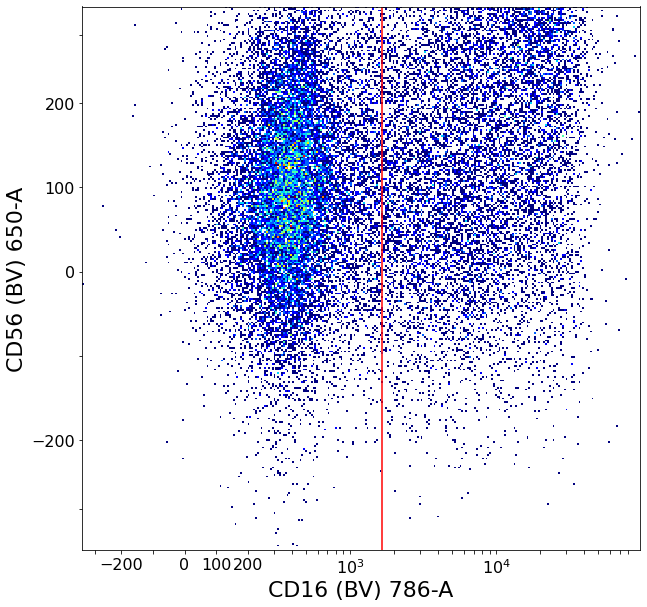

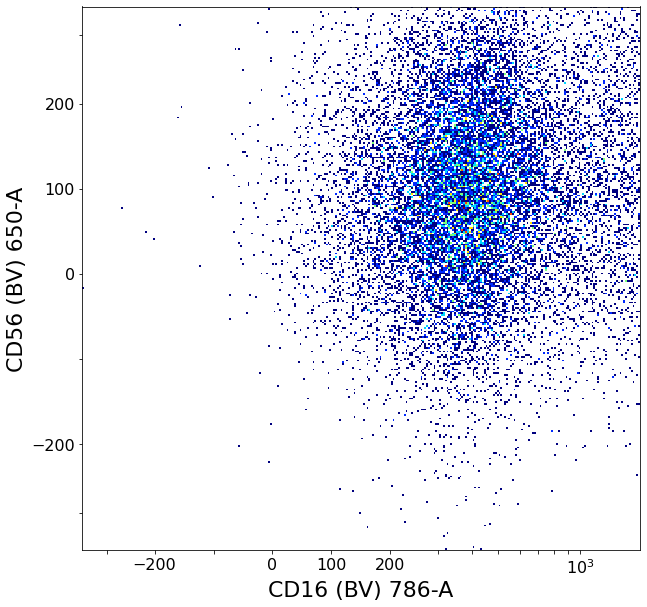

After gating, 18270 out of 28959 events remain.


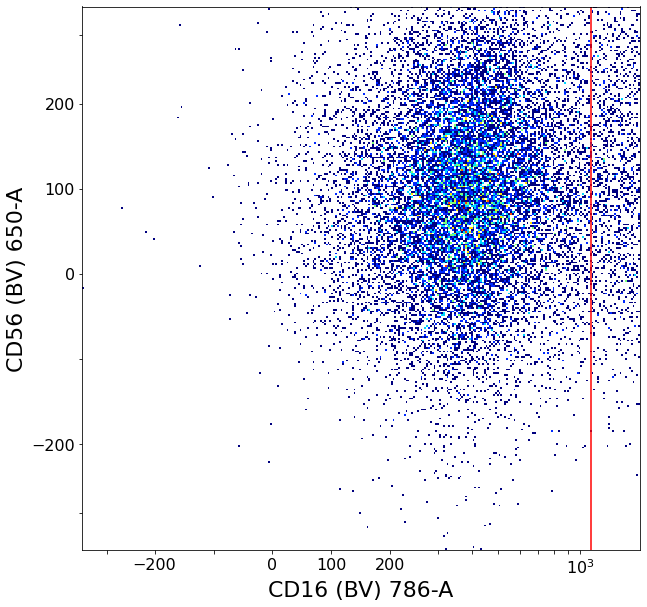

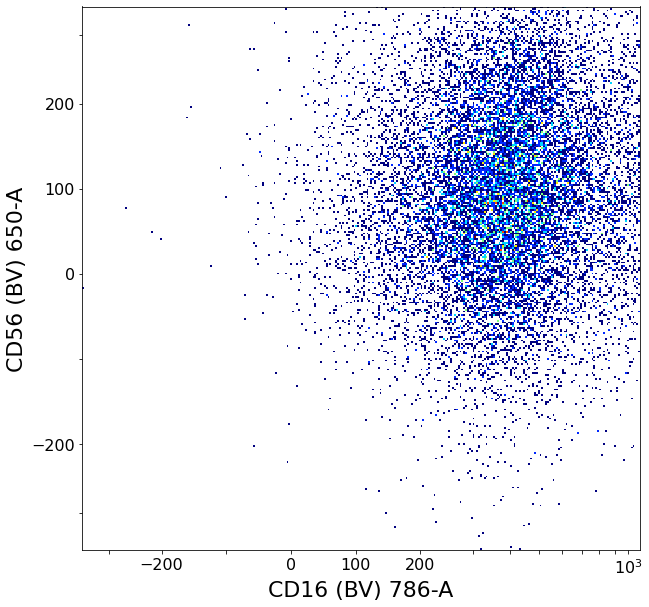

After gating, 16987 out of 18270 events remain.
After gating, 15994 out of 16987 events remain.


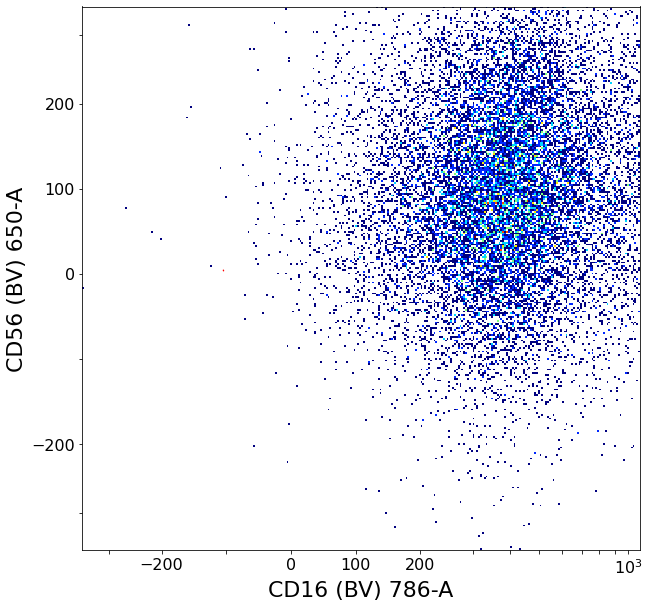

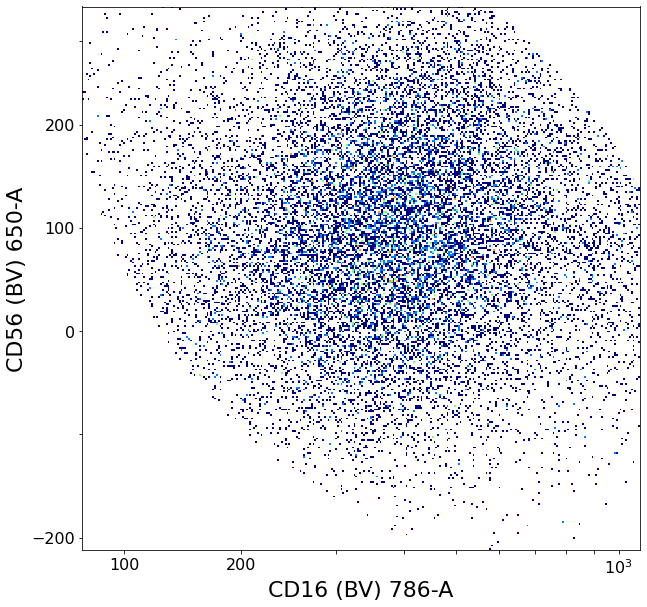

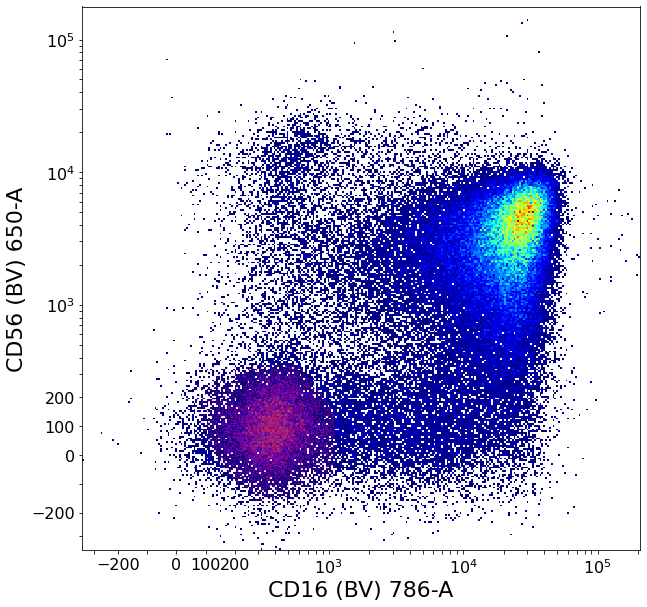

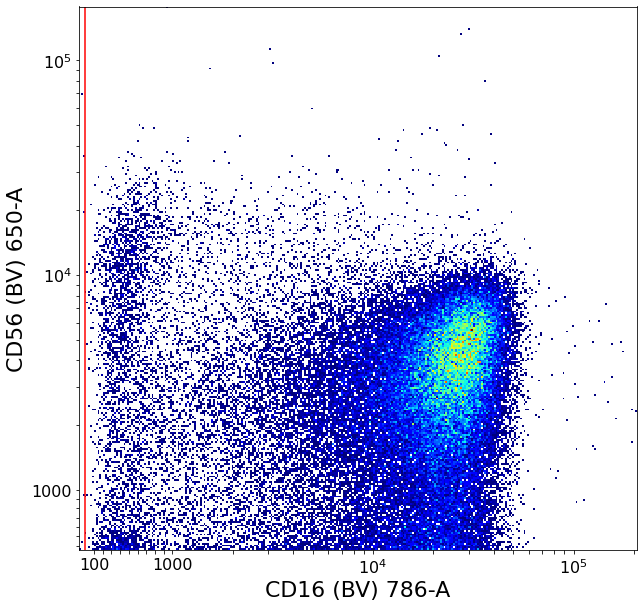

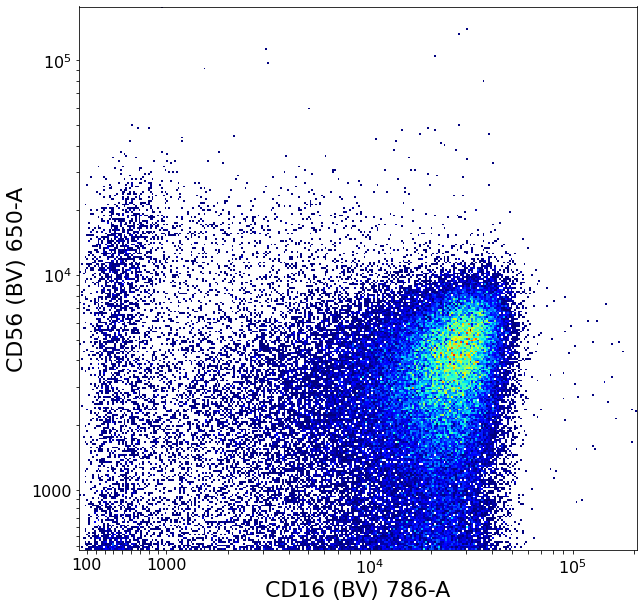

After gating, 72018 out of 72028 events remain.


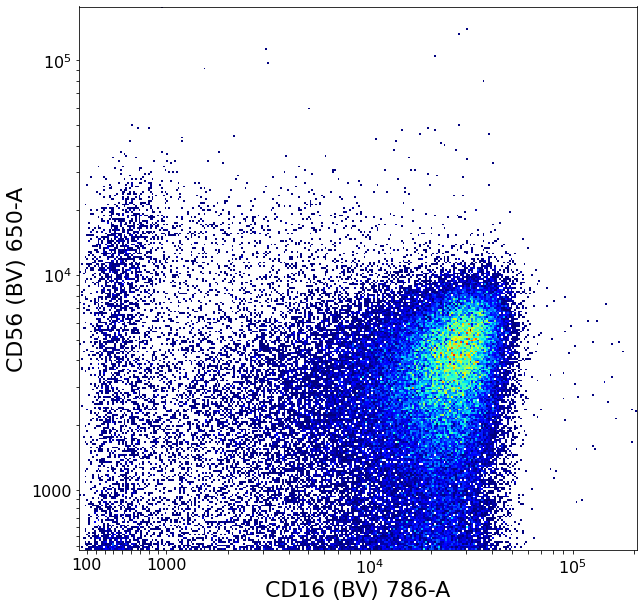

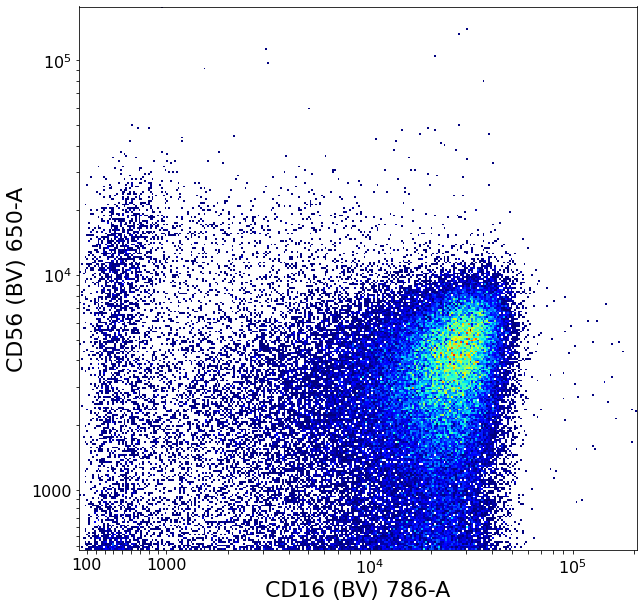

After gating, 72018 out of 72018 events remain.


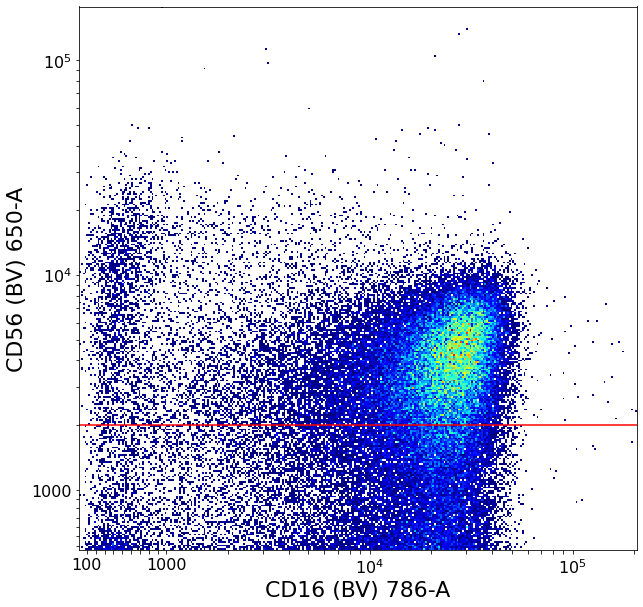

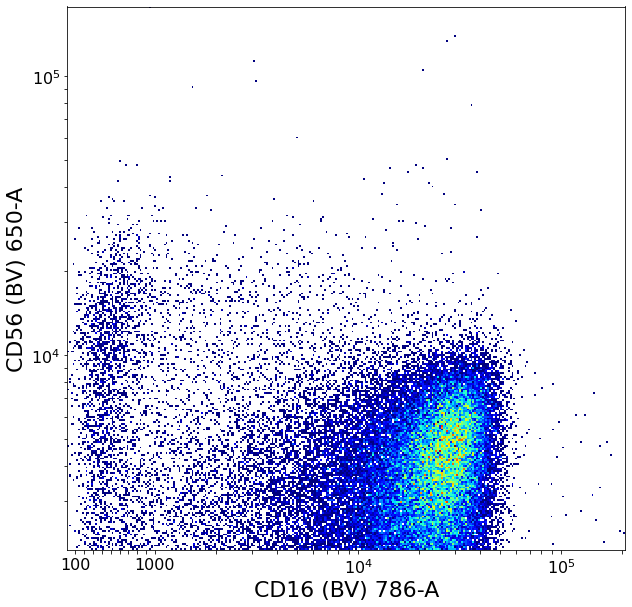

After gating, 48590 out of 72018 events remain.


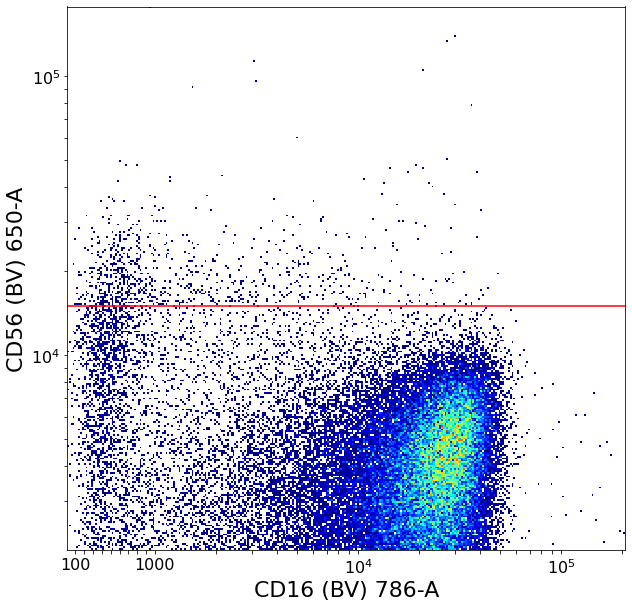

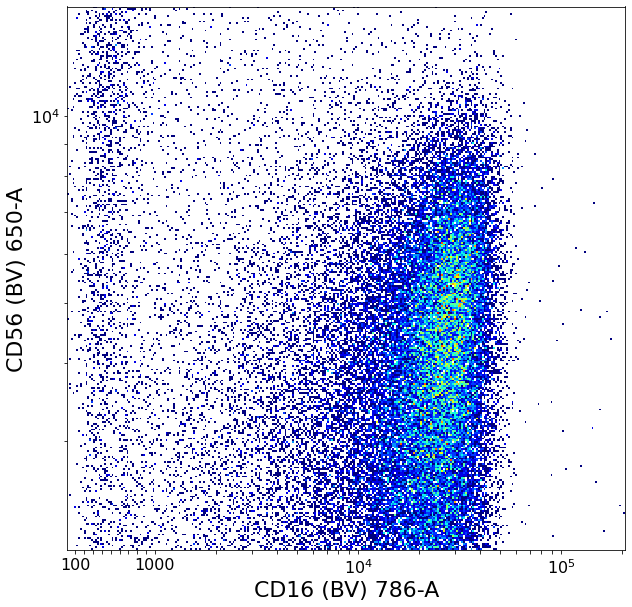

After gating, 47710 out of 48590 events remain.
After gating, 69652 out of 47710 events remain.
/tmp/ipykernel_79395/1243527683.py:21: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  central_section = ag.horizontalPath(my_sample, name="hor_path", xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', population='lower', startY=3000, endY=12000,  xboundaries=[0,500000], yboundaries=[2000,15000], leftRight=True , direction='both', maxStep=2, phi=0.1, bins=100, sigma=1, scale='bilog', T=200, parentGate=upper_half)


<Figure size 720x720 with 0 Axes>

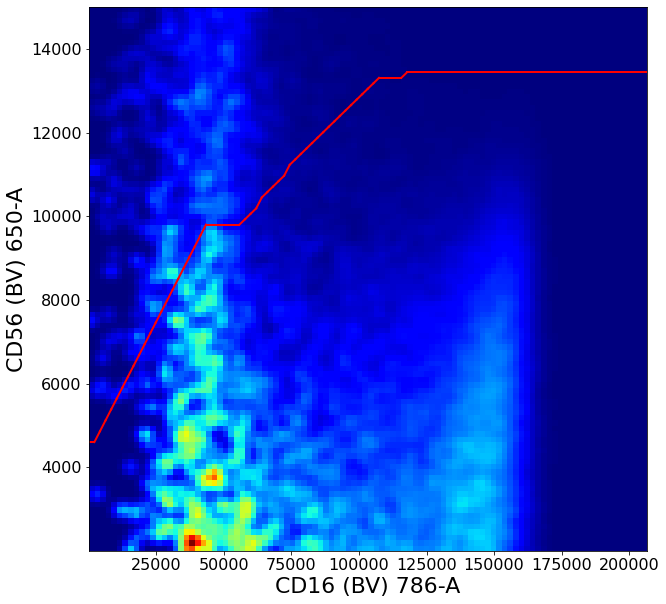

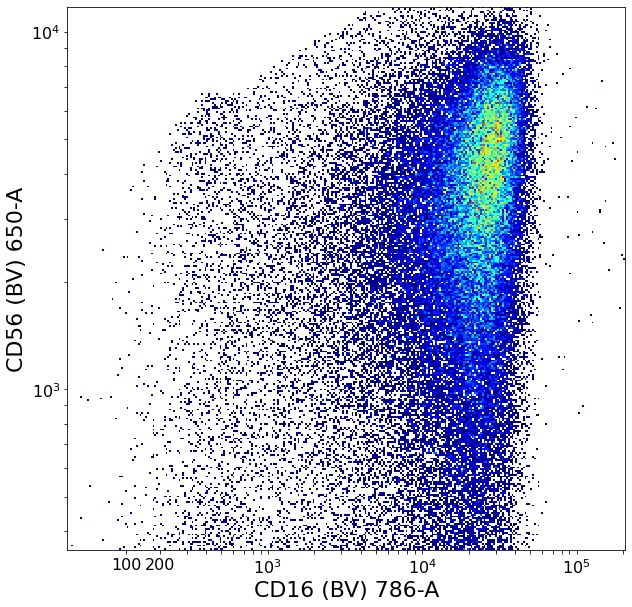

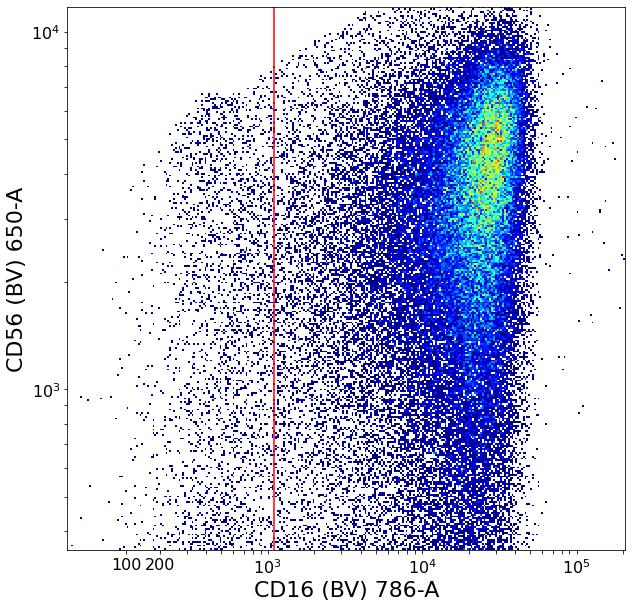

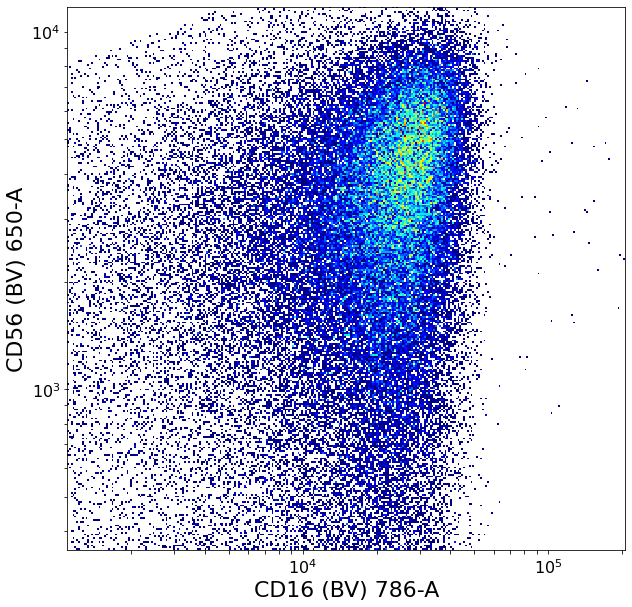

After gating, 66791 out of 69652 events remain.


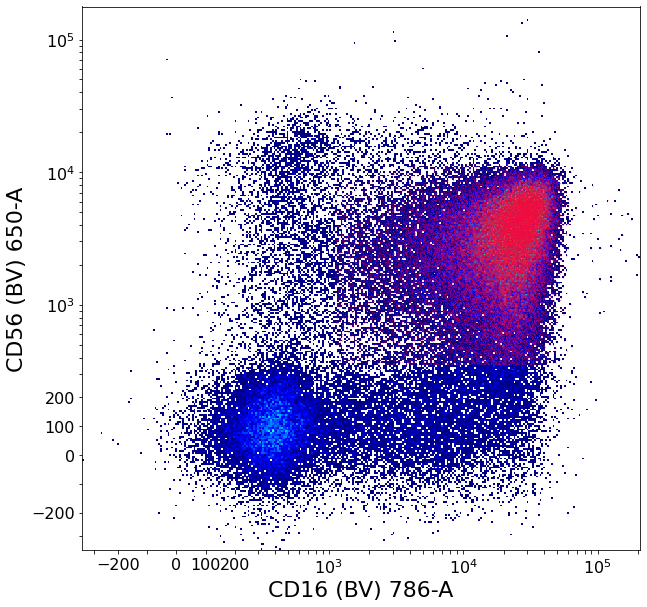

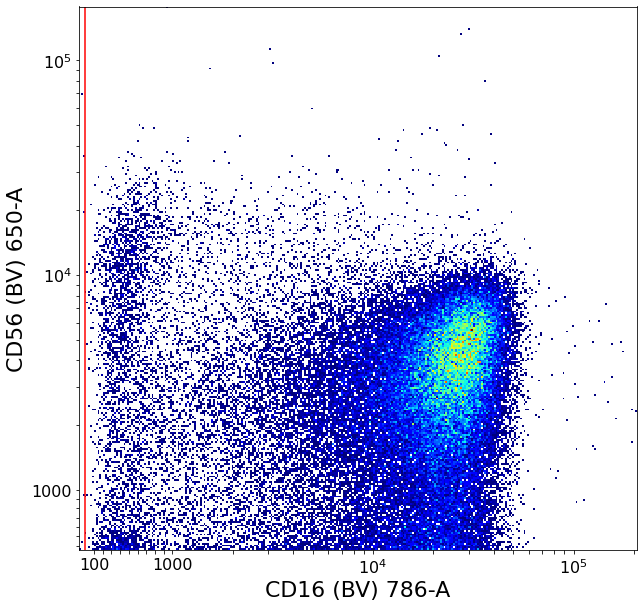

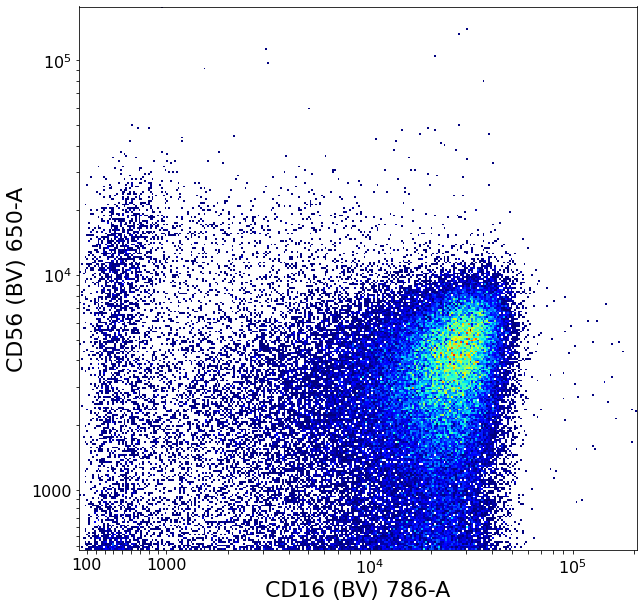

After gating, 72018 out of 72028 events remain.


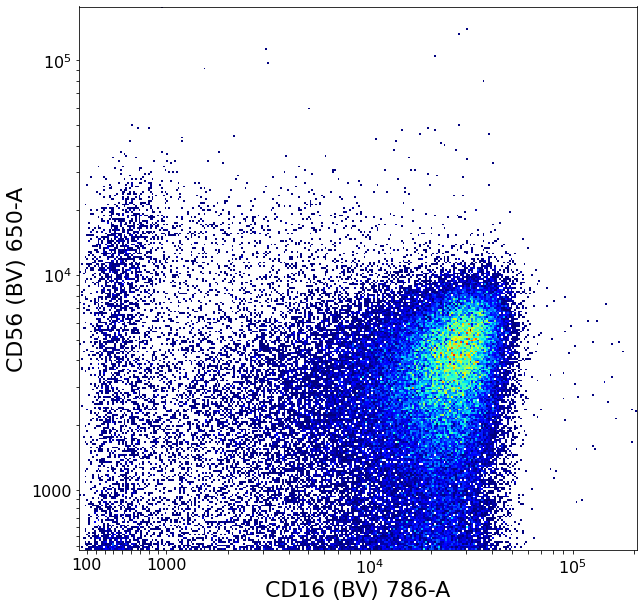

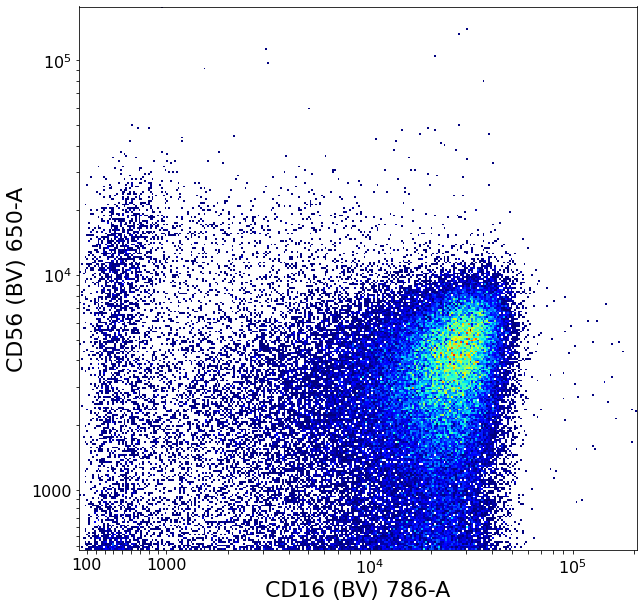

After gating, 72018 out of 72018 events remain.


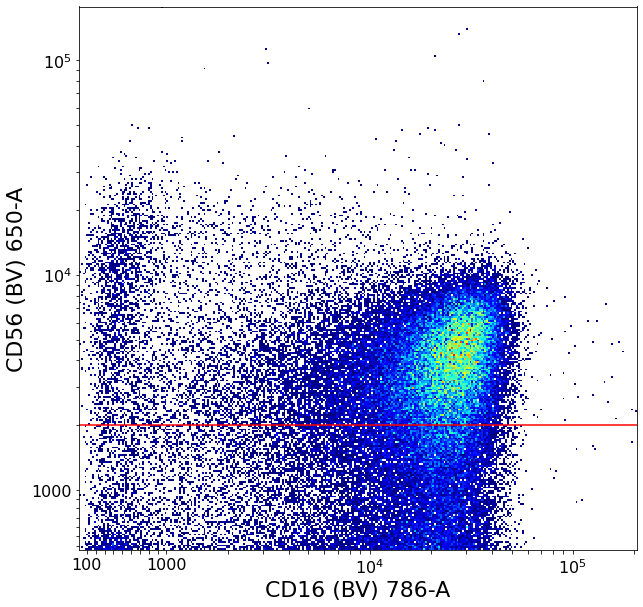

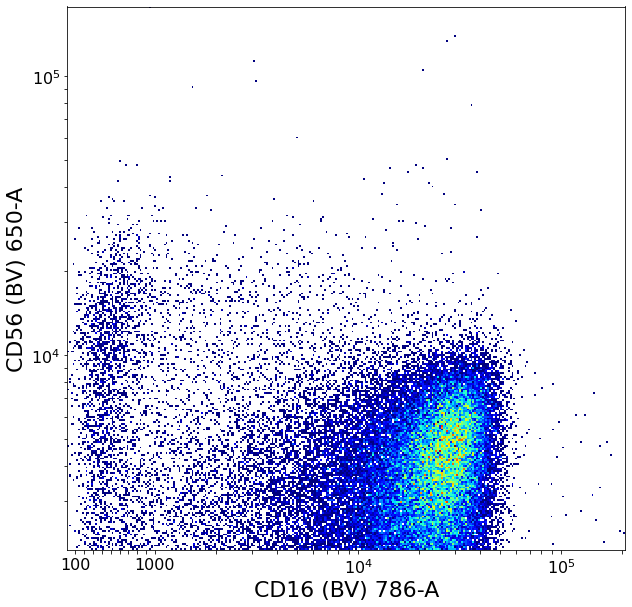

After gating, 48590 out of 72018 events remain.


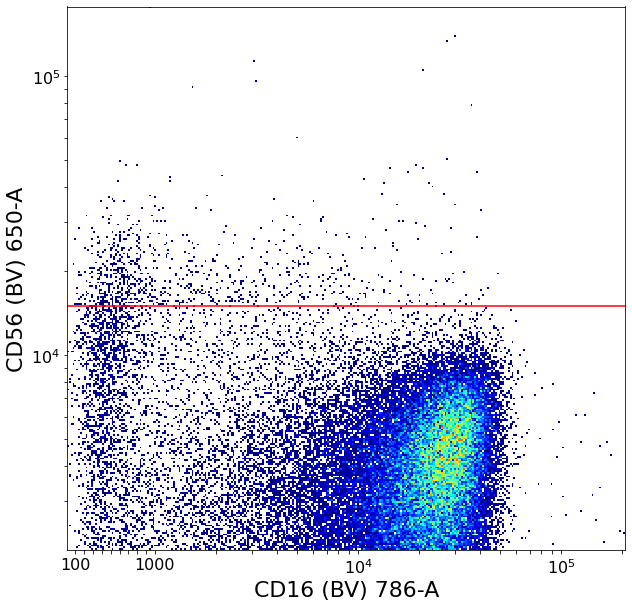

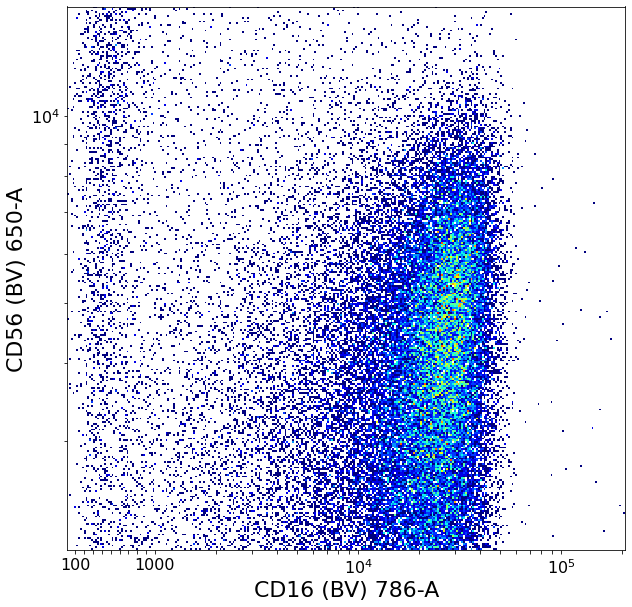

After gating, 47710 out of 48590 events remain.
After gating, 2376 out of 47710 events remain.
/tmp/ipykernel_79395/1243527683.py:28: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  CD16neg_56pospos_final = ag.horizontalPath(my_sample, name="CD16-CD56++", xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', population='upper', startY=3000, endY=12000, xboundaries=[0,500000], yboundaries=[2000,15000], leftRight=True , direction='both', maxStep=2, phi=0.1, bins=100, sigma=1, scale='bilog', T=200, parentGate=upper_half)


<Figure size 720x720 with 0 Axes>

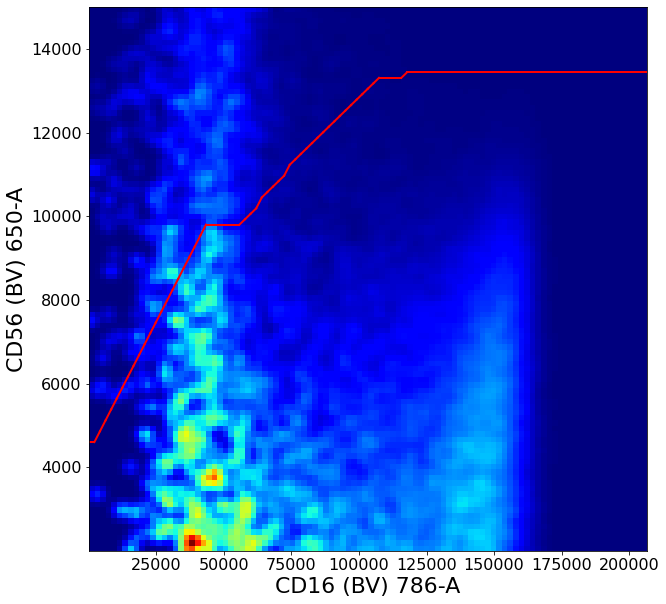

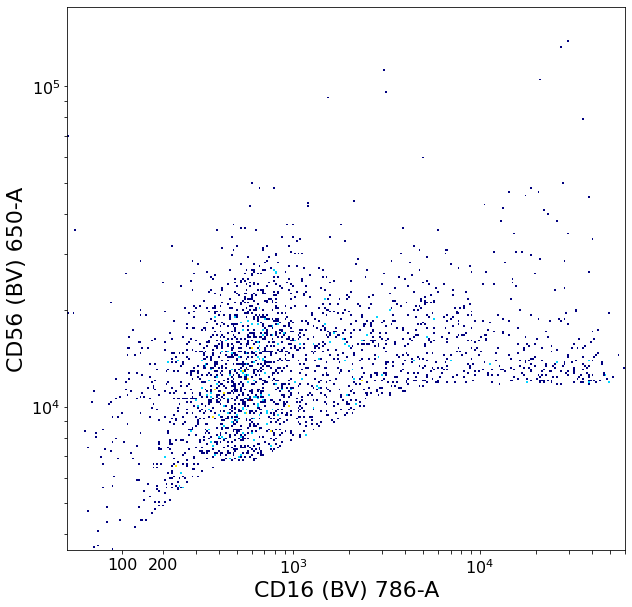

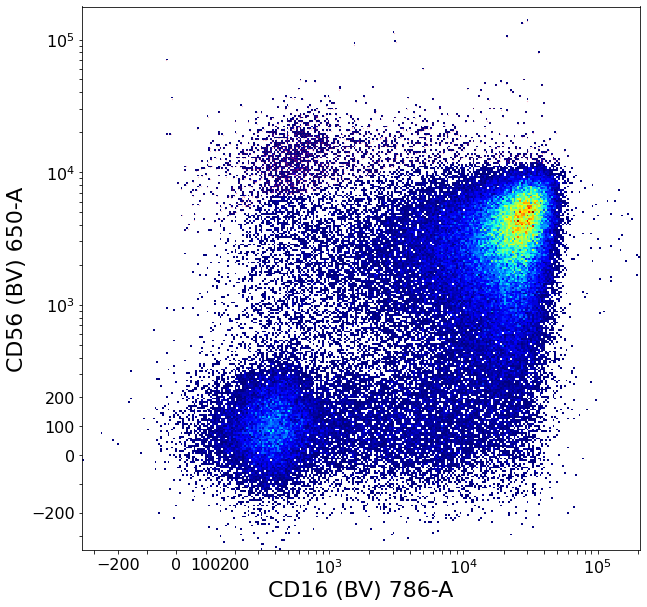

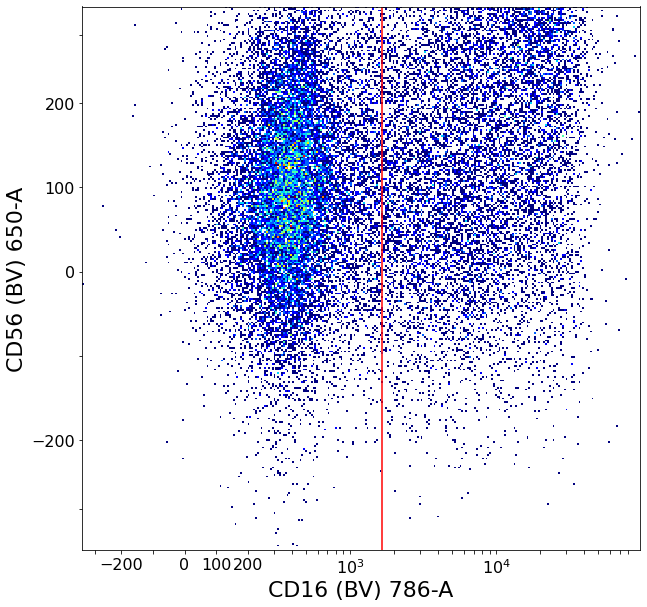

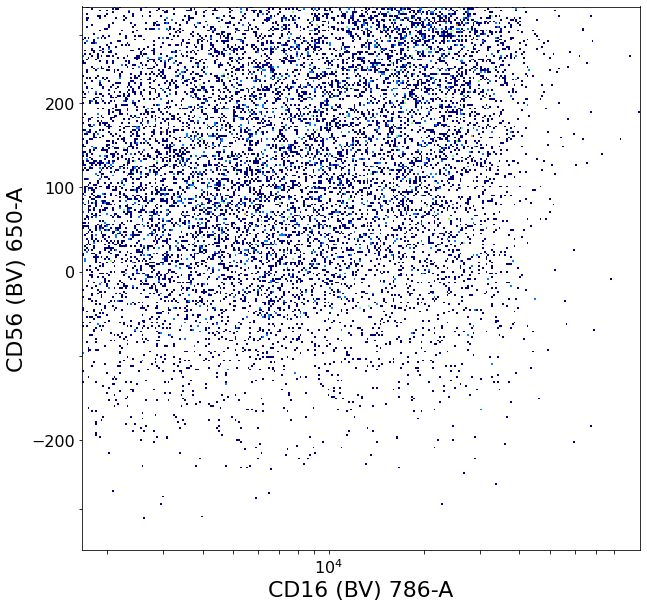

After gating, 10689 out of 28959 events remain.


In [17]:
## Gate 10: CD16 and CD56 values out of CD14-

aprox_xlim_middle = ag.valleySeek(my_sample, xCol='CD16 (BV) 786-A', interval=[900, 18000], require_local_min=True, scale='bilog', T=200, parentGate=CD14neg)    
left_half = ag.gateThreshold(my_sample, name="separate_middle", xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', scale='bilog', T=200, thresh=aprox_xlim_middle, parentGate=CD14neg, orientation='vertical', population='lower')    
aprox_ylim_middle = ag.valleySeek(my_sample, xCol='CD56 (BV) 650-A', interval=[700, 1300], require_local_min=True, scale='bilog', T=200, parentGate=CD14neg)    
lower_left_half = ag.gateThreshold(my_sample, name="separate_middle", xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', scale='bilog', T=200, thresh=aprox_ylim_middle, parentGate=left_half, orientation='horizontal', population='lower')    
main_ylim_middle = ag.densityDelimitation(my_sample, xCol='CD56 (BV) 650-A', parentGate=lower_left_half, interval=[0,2000], limit_threshold=0.07, direction='right',scale='linear')    
if main_ylim_middle == inf:
    main_ylim_middle = aprox_ylim_middle    
lower_half = ag.gateThreshold(my_sample, name="separate_middle", xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', scale='bilog', T=200, thresh=main_ylim_middle, parentGate=CD14neg, orientation='horizontal', population='lower')    
upper_half = ag.gateThreshold(my_sample, name="separate_middle", xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', scale='bilog', T=200, thresh=main_ylim_middle, parentGate=CD14neg, orientation='horizontal', population='upper')    
aprox_xlim_middle2 = ag.valleySeek(my_sample, xCol='CD16 (BV) 786-A', interval=[900, 18000], require_local_min=True, scale='bilog', T=200, parentGate=lower_half)    
CD16neg_56neg_step1 = ag.gateThreshold(my_sample, name="lower_left_side", xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', scale='bilog', T=200, thresh=aprox_xlim_middle2, parentGate=lower_half, orientation='vertical', population='lower')    
main_xlim_middle = ag.densityDelimitation(my_sample, xCol='CD16 (BV) 786-A', parentGate=CD16neg_56neg_step1, interval=[0,2000], limit_threshold=0.07, direction='right',scale='linear')
if main_xlim_middle == inf:
    main_xlim_middle = aprox_xlim_middle    
CD16neg_56neg_step2 = ag.gateThreshold(my_sample, name="separate_middle", xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', scale='bilog', T=200, thresh=main_xlim_middle, parentGate=CD16neg_56neg_step1, orientation='vertical', population='lower')
    ## CD16-CD56-, a.k.a. LIN NEGATIVE
CD16neg_56neg_final = ag.gatePC(my_sample, name="CD16-CD56-", xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', center='centroid', adjustAngle=0,widthScale=2, scale='bilog', T=200, heightScale=3.5, parentGate=CD16neg_56neg_step2)
ag.backGate(my_sample, population=CD16neg_56neg_final, background_population=CD14neg, xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', scale='bilog', T=200, markersize=0.1)
central_section = ag.horizontalPath(my_sample, name="hor_path", xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', population='lower', startY=3000, endY=12000,  xboundaries=[0,500000], yboundaries=[2000,15000], leftRight=True , direction='both', maxStep=2, phi=0.1, bins=100, sigma=1, scale='bilog', T=200, parentGate=upper_half)   
     ## CD16++CD56++
CD16pospos_56pospos_final = ag.gateThreshold(my_sample, name="CD16+CD56+", xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', scale='bilog', T=200, thresh=main_xlim_middle, parentGate=central_section, orientation='vertical', population='upper')
ag.backGate(my_sample, population=CD16pospos_56pospos_final, background_population=CD14neg, xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', scale='bilog', T=200, markersize=0.1)

my_sample.update(ag.AGgate(CD16pospos_56pospos_final, CD45pos,'CD16 (BV) 786-A' ,'CD56 (BV) 650-A',"CD16++CD56++"), QC=False)
    ## CD16-CD56++    
CD16neg_56pospos_final = ag.horizontalPath(my_sample, name="CD16-CD56++", xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', population='upper', startY=3000, endY=12000, xboundaries=[0,500000], yboundaries=[2000,15000], leftRight=True , direction='both', maxStep=2, phi=0.1, bins=100, sigma=1, scale='bilog', T=200, parentGate=upper_half)
ag.backGate(my_sample, population=CD16neg_56pospos_final, background_population=CD14neg, xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', scale='bilog', T=200, markersize=0.1)

my_sample.update(ag.AGgate(CD16neg_56pospos_final, CD45pos,'CD16 (BV) 786-A' ,'CD56 (BV) 650-A',"CD16-CD56++"), QC=False)
    ## CD16++CD56-
CD16pospos_56neg_final = ag.gateThreshold(my_sample, name="CD16++CD56-", xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', scale='bilog', T=200, thresh=aprox_xlim_middle2, parentGate=lower_half, orientation='vertical', population='upper')

my_sample.update(ag.AGgate(CD16pospos_56neg_final, CD45pos,'CD16 (BV) 786-A' ,'CD56 (BV) 650-A',"CD16++CD56-"), QC=False)


## Gate 11: Lin-CD34+ out of CD16-CD56-/CD14-/CD19-/CD3-/CD45+

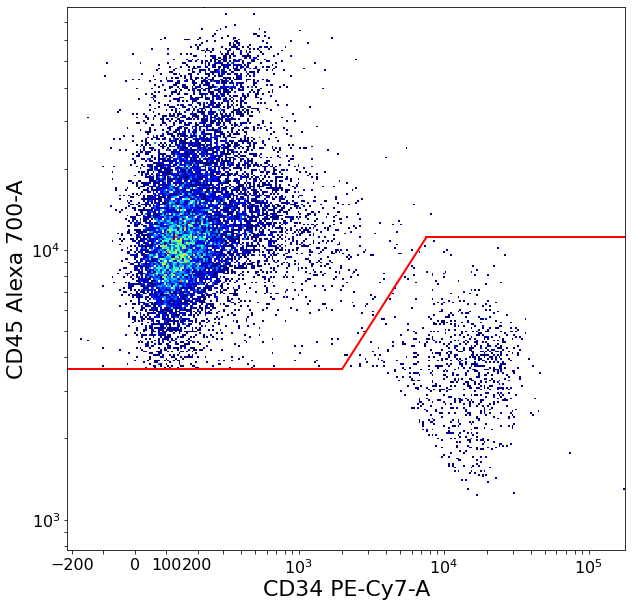

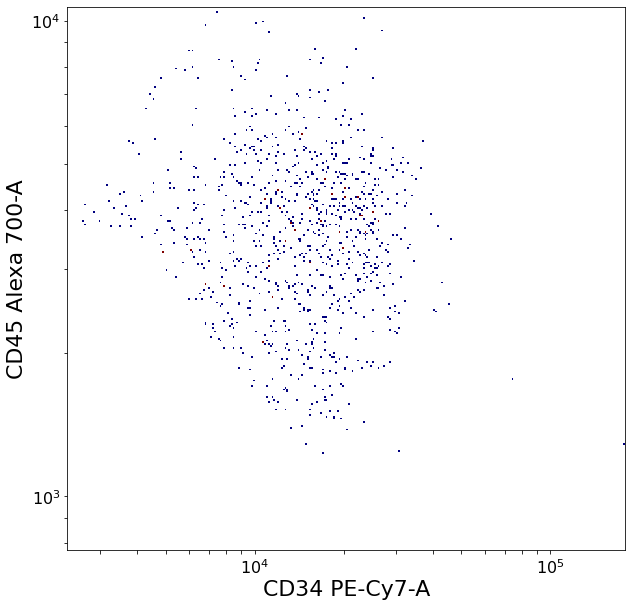

After gating, 930 out of 949 events remain.


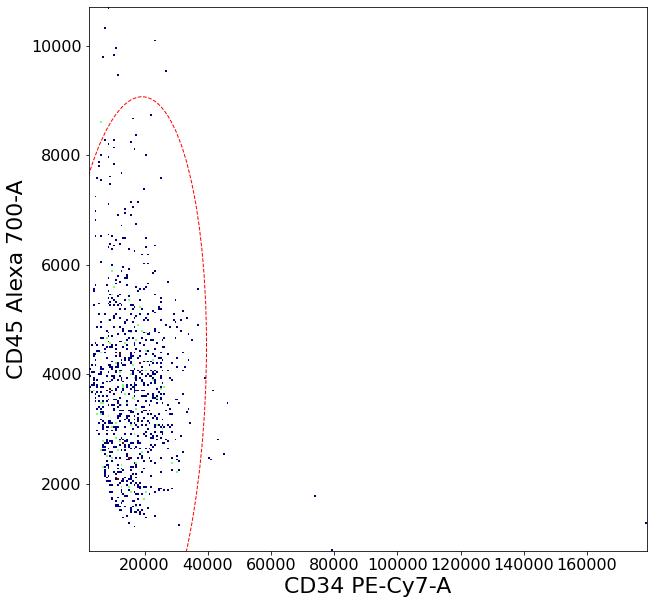

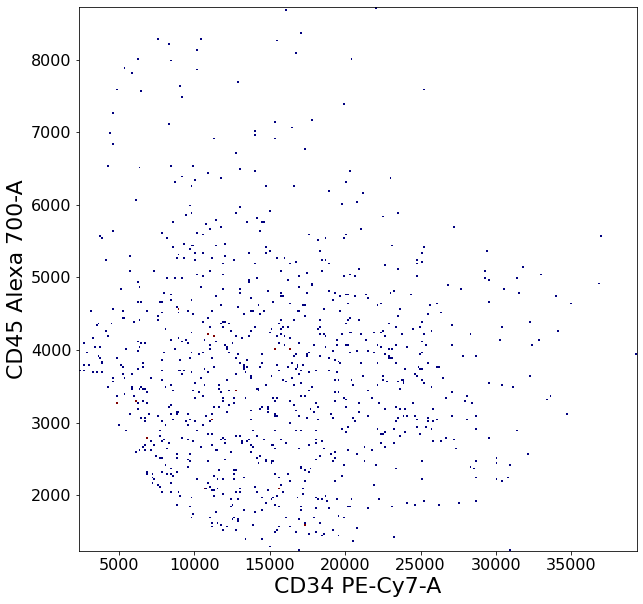

<Figure size 720x720 with 0 Axes>

In [18]:
## Gate 11: Lin-CD34+ out of CD16-CD56-/CD14-/CD19-/CD3-/CD45+

CD34pos_step1 = ag.gateTiltedLine(my_sample, name="tilted_gate_cd34", xCol='CD34 PE-Cy7-A' , yCol=CD45, startPoint=(xlim_middle,maxVal), endLimits=(None, maxVal+7500), theta=40, scale='bilog', T=200, population='lower', parentGate=CD16neg_56neg_final)
linnegCD34pos = ag.gatePC(my_sample, name="Lin-CD34+", xCol='CD34 PE-Cy7-A' , yCol=CD45, center='centroid', adjustAngle=3,widthScale=2.5, heightScale=3.5, parentGate=CD34pos_step1)

my_sample.update(ag.AGgate(linnegCD34pos, CD45pos,'CD34 PE-Cy7-A' , CD45,"linneg_cd34pos"), QC=True,  scale='bilog', xscale='bilog', yscale='bilog', T=200, xlim=[-1000, 80000], ylim=[0, 150000])


## Gate 12: CD38 out of Lin-CD34+ (PLACEHOLDER until new CD38 gate is developed)

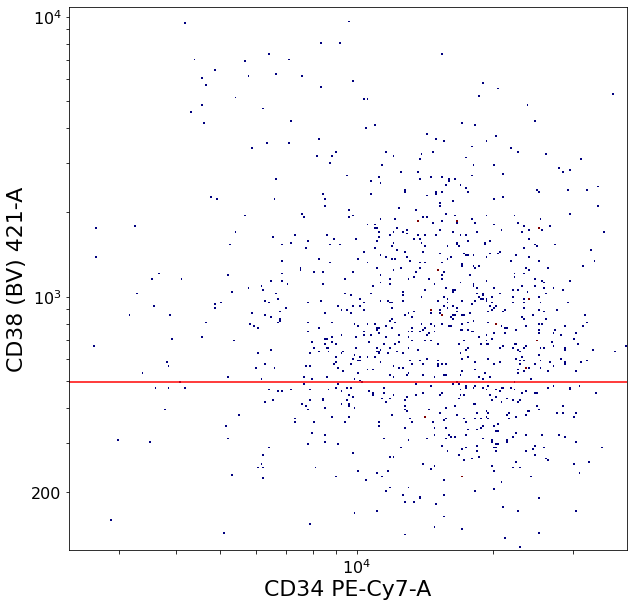

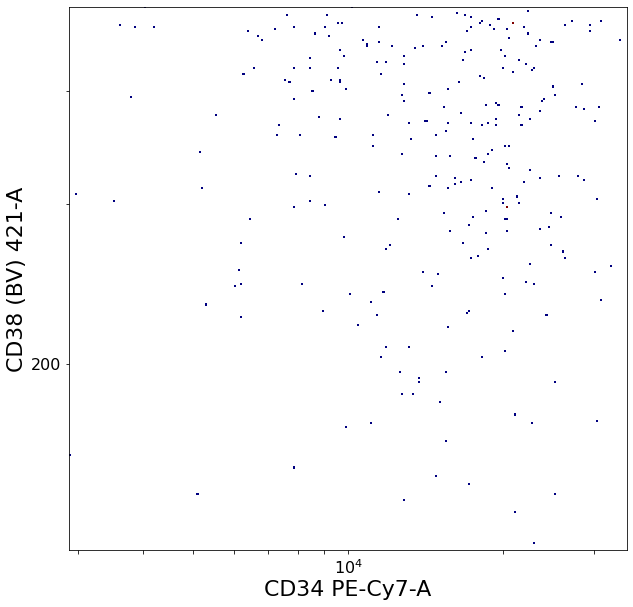

After gating, 267 out of 930 events remain.


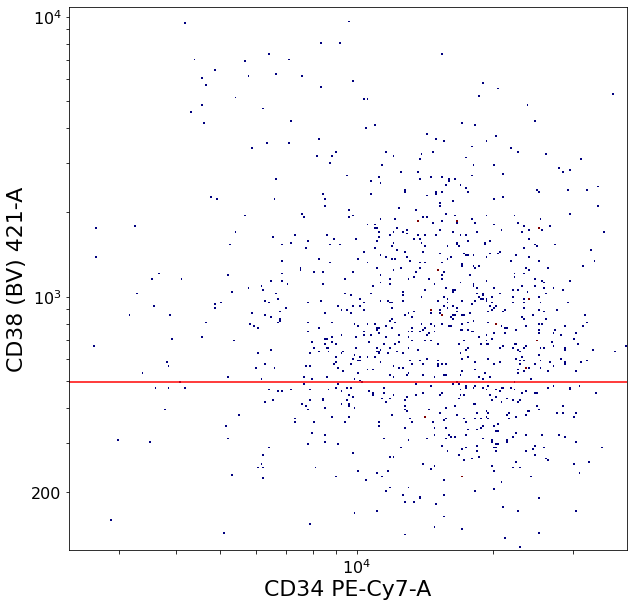

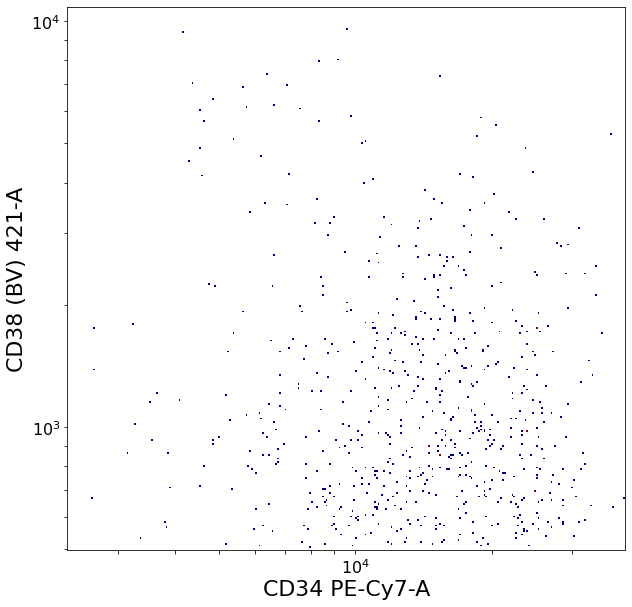

After gating, 663 out of 930 events remain.


In [19]:
## Gate 12: CD38 out of Lin-CD34+ (PLACEHOLDER until new CD38 gate is developed)

gated_df = my_sample.fcsDF.loc[CD34pos()].copy()
cd38_values_list = sorted(list(gated_df['CD38 (BV) 421-A']))
if cd38_values_list:  #If the list is not empty
    index = int(len(cd38_values_list)*0.3)
    ylim_middle = cd38_values_list[index]
else:
    print("FATAL ERROR")

    ## Gate 12A: CD38-

CD38neg= ag.gateThreshold(my_sample, name="CD38-", xCol='CD34 PE-Cy7-A' , yCol='CD38 (BV) 421-A',  scale='bilog', T=200, thresh=ylim_middle, parentGate=linnegCD34pos, orientation='horizontal', population='lower')
    ## Gate 12B: CD38+
CD38pos = ag.gateThreshold(my_sample, name="CD38+", xCol='CD34 PE-Cy7-A' , yCol='CD38 (BV) 421-A',  scale='bilog', T=200, thresh=ylim_middle, parentGate=linnegCD34pos, orientation='horizontal', population='upper')


## Gate 13: HSCs, MPPs and MLPs out of CD38-

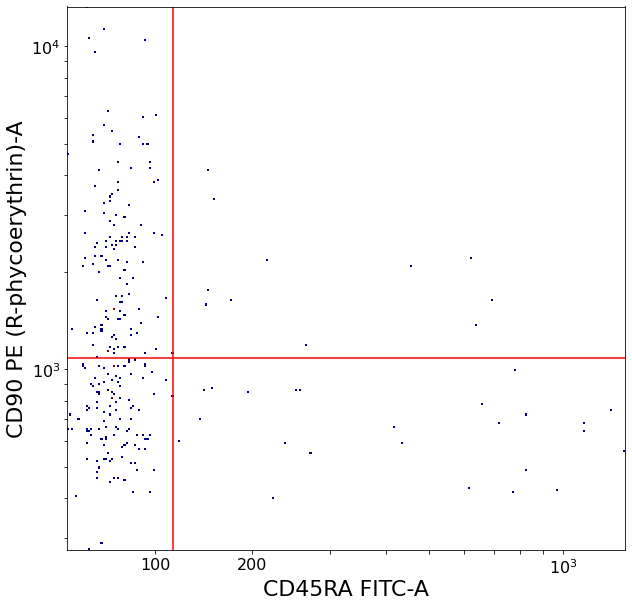

quadGate results in clockwise order from top-left: 119, 11, 24, 113


In [20]:
## Gate 13: HSCs, MPPs and MLPs out of CD38-

ylim = ag.densityDelimitation(my_sample, xCol='CD90 PE (R-phycoerythrin)-A', interval=[200,5000], limit_threshold=0.5, direction='right',scale='bilog',T=200, parentGate=CD38neg)    
xlim = ag.densityDelimitation(my_sample, xCol='CD45RA FITC-A', interval=[-100,300], limit_threshold=0.05, direction='right',scale='bilog',T=200, parentGate=CD38neg)   
if ylim == inf:  # Plan B... RATHER PROBLEMATIC BECAUSE IT'S INCONSISTENT!!!
    right_hand= ag.gateThreshold(my_sample, name="remove_clutter_3", xCol='CD45RA FITC-A', yCol='CD90 PE (R-phycoerythrin)-A', scale='bilog', T=200, thresh=xlim, parentGate=CD38neg, orientation='vertical', population='upper')        
    ylim = ag.densityDelimitation(my_sample, xCol='CD90 PE (R-phycoerythrin)-A', interval=[200,5000], limit_threshold=0.2, direction='right',scale='bilog',T=200, parentGate=right_hand)
    if ylim == inf:
        ylim = 5000  # Plan C...

HSC, irrelevant, MLP, MPP = ag.quadGate(my_sample, names=['HSC', 'NA', 'MLP', 'MPP'], xCol='CD45RA FITC-A', yCol='CD90 PE (R-phycoerythrin)-A', xThresh=xlim, yThresh=ylim, scale='bilog', T=200, parentGate=CD38neg)

my_sample.update(ag.AGgate(HSC, CD34pos,'CD45RA FITC-A', 'CD90 PE (R-phycoerythrin)-A',"HSC_1"), QC=True, scale='bilog', xscale='bilog', yscale='bilog', T=200, xlim=[0, 1000], ylim=[300, 11000])
my_sample.update(ag.AGgate(HSC, linnegCD34pos,'CD45RA FITC-A', 'CD90 PE (R-phycoerythrin)-A',"HSC_2"), QC=False)
my_sample.update(ag.AGgate(MLP, CD34pos,'CD45RA FITC-A', 'CD90 PE (R-phycoerythrin)-A',"MLP_1"), QC=False)
my_sample.update(ag.AGgate(MLP, linnegCD34pos,'CD45RA FITC-A', 'CD90 PE (R-phycoerythrin)-A',"MLP_2"), QC=False)
my_sample.update(ag.AGgate(MPP, CD34pos,'CD45RA FITC-A', 'CD90 PE (R-phycoerythrin)-A',"MPP_1"), QC=False)
my_sample.update(ag.AGgate(MPP, linnegCD34pos,'CD45RA FITC-A', 'CD90 PE (R-phycoerythrin)-A',"MPP_2"), QC=False)


## Gate 14: non-BNK (CD10neg) and B-NK out of CD38+

/home/antton/Programs/aligater/aligater/AGPlotRoutines.py:201: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  cmap.set_bad(color='white') #Zeroes should be white, not blue


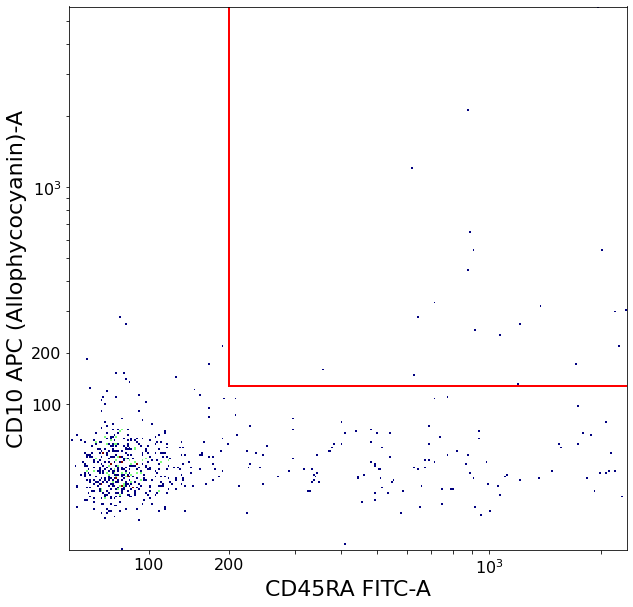

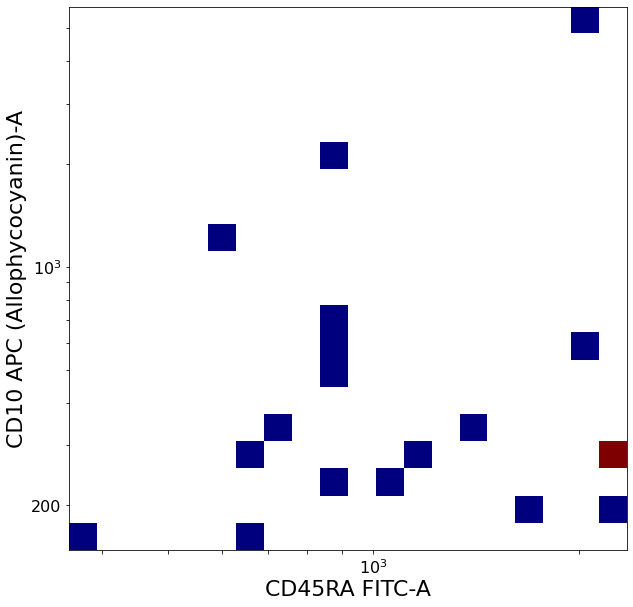

After gating, 20 out of 663 events remain.


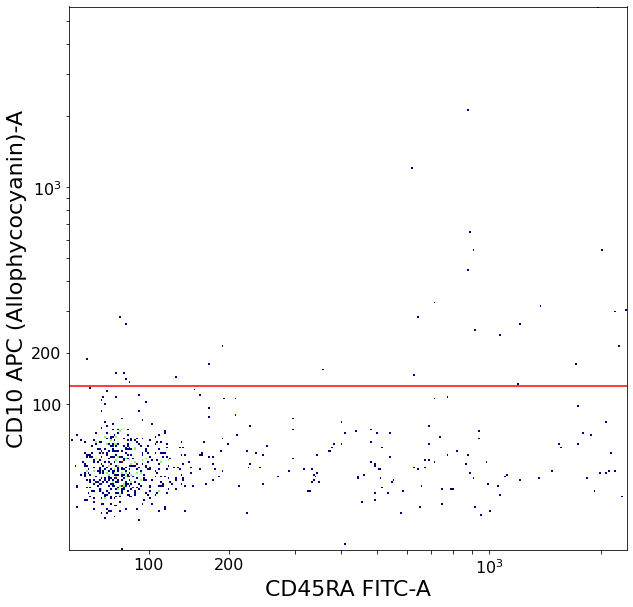

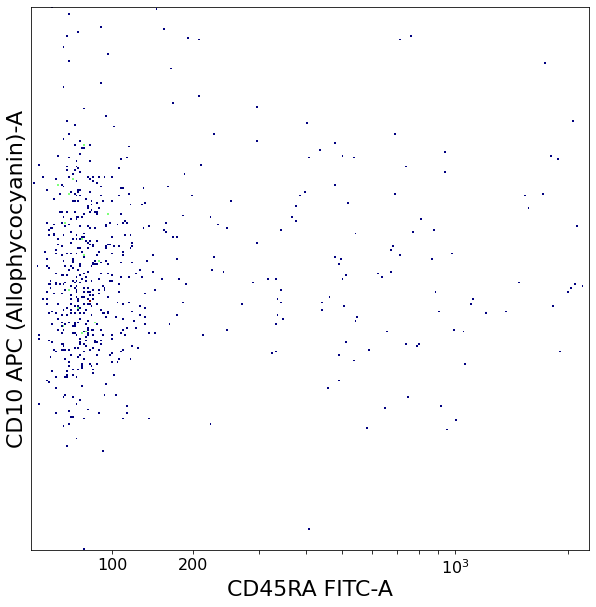

After gating, 633 out of 663 events remain.


In [21]:
## Gate 14: non-BNK (CD10neg) and B-NK out of CD38+

ylim_cd10 = ag.densityDelimitation(my_sample, xCol='CD10 APC (Allophycocyanin)-A', parentGate=halfcut, interval=[-100,800], limit_threshold=0.2, direction='right',scale='bilog',T=200)

    ## B-NK progenitors, CD10+?

BNK_prog = ag.gateCorner(my_sample, name="BNK", xCol='CD45RA FITC-A', yCol='CD10 APC (Allophycocyanin)-A', xThresh=200, yThresh=ylim_cd10, xOrientation='upper', yOrientation='upper', Outer=False, scale='bilog', T=200, parentGate=CD38pos)

my_sample.update(ag.AGgate(BNK_prog, CD38pos,'CD45RA FITC-A', 'CD10 APC (Allophycocyanin)-A',"B-NK_1"), QC=False) 
my_sample.update(ag.AGgate(BNK_prog, CD34pos,'CD45RA FITC-A', 'CD10 APC (Allophycocyanin)-A',"B-NK_2"), QC=False)
my_sample.update(ag.AGgate(BNK_prog, linnegCD34pos,'CD45RA FITC-A', 'CD10 APC (Allophycocyanin)-A',"B-NK_3"), QC=False)

    ## CD10-
nonBNK= ag.gateThreshold(my_sample, name="CD10-", xCol='CD45RA FITC-A', yCol='CD10 APC (Allophycocyanin)-A', scale='bilog', T=200, thresh=ylim_cd10, parentGate=CD38pos, orientation='horizontal', population='lower')


## Gate 15: CD10 out of MLP

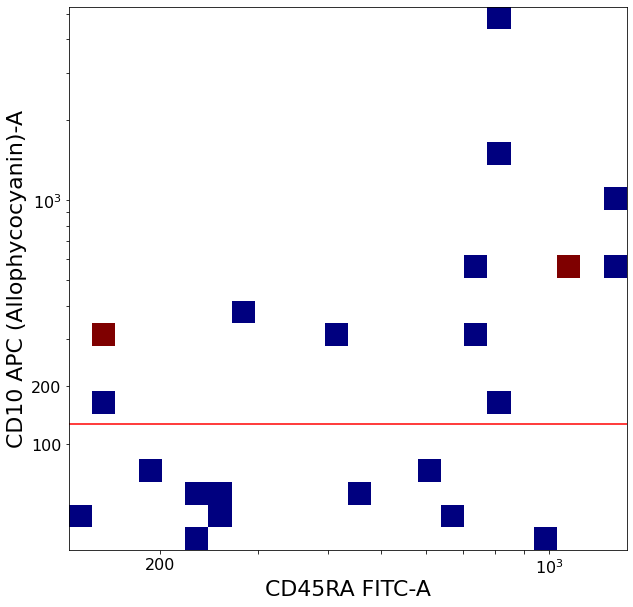

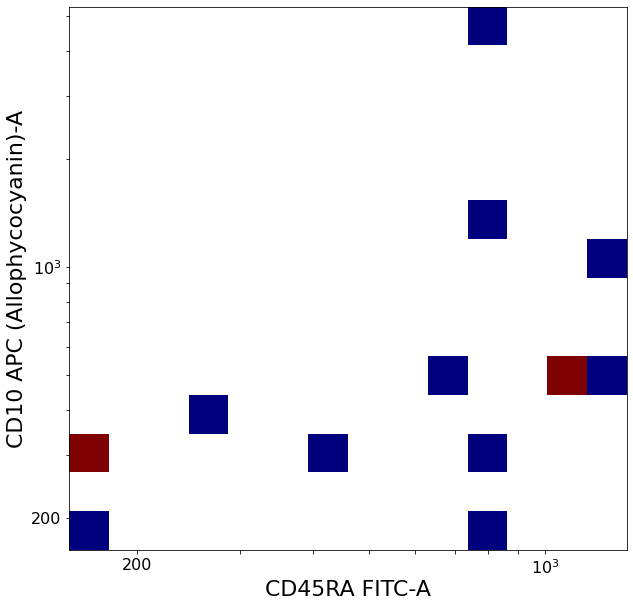

After gating, 14 out of 24 events remain.


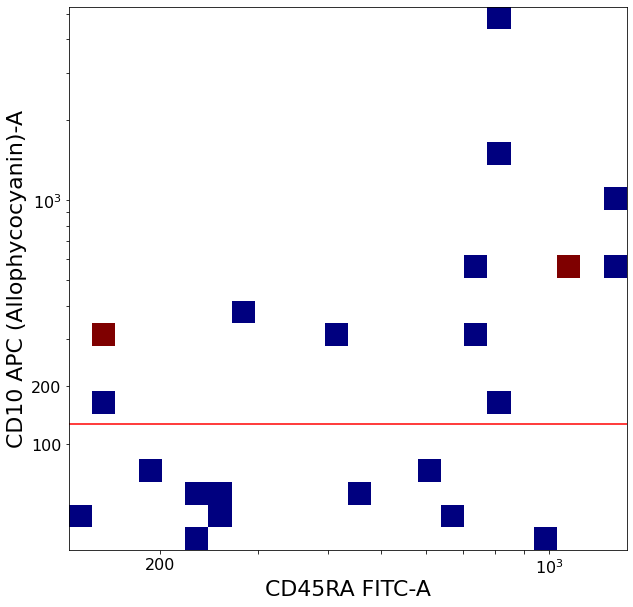

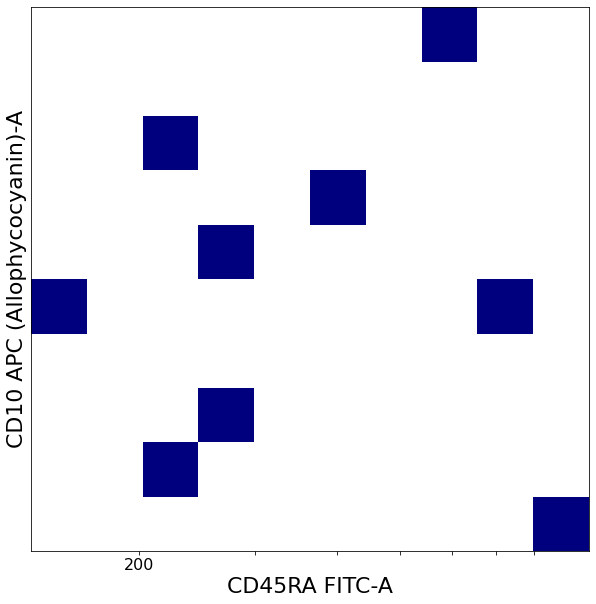

After gating, 10 out of 24 events remain.


In [22]:
## Gate 15: CD10 out of MLP

CD10pos_MLP = ag.gateThreshold(my_sample, name="cd10+_MLP", xCol='CD45RA FITC-A', yCol='CD10 APC (Allophycocyanin)-A', scale='bilog', T=200, thresh=ylim_cd10, parentGate=MLP, orientation='horizontal', population='upper')
CD10neg_MLP = ag.gateThreshold(my_sample, name="cd10-_MLP", xCol='CD45RA FITC-A', yCol='CD10 APC (Allophycocyanin)-A', scale='bilog', T=200, thresh=ylim_cd10, parentGate=MLP, orientation='horizontal', population='lower')

my_sample.update(ag.AGgate(CD10pos_MLP, MLP,'CD45RA FITC-A', 'CD135 (BV) 711-A',"CD10+(MLP)_1"), QC=False)
my_sample.update(ag.AGgate(CD10pos_MLP, CD34pos,'CD45RA FITC-A', 'CD135 (BV) 711-A',"CD10+(MLP)_2"), QC=False)
my_sample.update(ag.AGgate(CD10pos_MLP, linnegCD34pos,'CD45RA FITC-A', 'CD135 (BV) 711-A',"CD10+(MLP)_3"), QC=False)
my_sample.update(ag.AGgate(CD10neg_MLP, MLP,'CD45RA FITC-A', 'CD135 (BV) 711-A',"CD10-(MLP)_1"), QC=False)
my_sample.update(ag.AGgate(CD10neg_MLP, CD34pos,'CD45RA FITC-A', 'CD135 (BV) 711-A',"CD10-(MLP)_2"), QC=False)
my_sample.update(ag.AGgate(CD10neg_MLP, linnegCD34pos,'CD45RA FITC-A', 'CD135 (BV) 711-A',"CD10-(MLP)_3"), QC=False)    


## Gate 16: CNPs, GMPs and MEPs out of non-BNK CD38+ cells

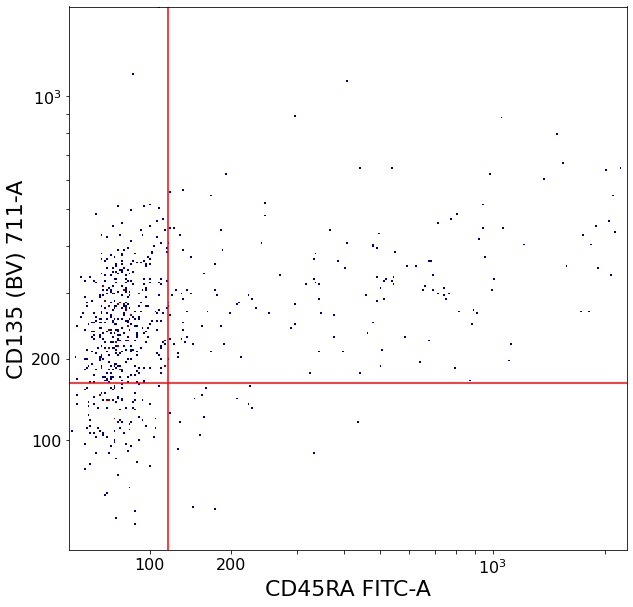

quadGate results in clockwise order from top-left: 373, 148, 17, 95


In [23]:
## Gate 16: CNPs, GMPs and MEPs out of non-BNK CD38+ cells

ylim = ag.densityDelimitation(my_sample, xCol='CD135 (BV) 711-A', interval=[-100,800], limit_threshold=0.5, direction='left',scale='bilog',T=200, parentGate=nonBNK)

xlim_cut_tail = ag.densityDelimitation(my_sample, xCol='CD45RA FITC-A', interval=[-100,800], limit_threshold=0.2, direction='right',scale='bilog',T=200, parentGate=nonBNK)

CMP, GMP, irrelevant, MEP = ag.quadGate(my_sample, names=['CMP', 'GMP', 'NA', 'MEP'], xCol='CD45RA FITC-A', yCol='CD135 (BV) 711-A', xThresh=xlim_cut_tail, yThresh=ylim, scale='bilog', T=200,  parentGate=nonBNK)

my_sample.update(ag.AGgate(CMP, CD34pos,'CD45RA FITC-A', 'CD135 (BV) 711-A',"CMP_1"), QC=False)
my_sample.update(ag.AGgate(CMP, linnegCD34pos,'CD45RA FITC-A', 'CD135 (BV) 711-A',"CMP_2"), QC=False)
my_sample.update(ag.AGgate(MEP, CD34pos,'CD45RA FITC-A', 'CD135 (BV) 711-A',"MEP_1"), QC=False)
my_sample.update(ag.AGgate(MEP, linnegCD34pos,'CD45RA FITC-A', 'CD135 (BV) 711-A',"MEP_2"), QC=False)
my_sample.update(ag.AGgate(GMP, CD34pos,'CD45RA FITC-A', 'CD135 (BV) 711-A',"GMP_1"), QC=False)
my_sample.update(ag.AGgate(GMP, linnegCD34pos,'CD45RA FITC-A', 'CD135 (BV) 711-A',"GMP_2"), QC=False)
